In [4]:
########################################################
# Capstone Project: Analyst Earnings Forecast Analysis #
# Team 5                                               #
# Date: March 2021                                     #
# Updated: April 2020                                  #
#                                                      #
# Abhishek Chand                                       #
# Shreya Deshmukh                                      #
# Tommy Li                                             #
# Martin Ma                                            #
# Jiseon Park                                          #
########################################################
# For S&P500 Companies


In [5]:
# First create a link file to Link CRSP and IBES    
# This creates a linking table between CRSP and IBES
# Output is a score reflecting the quality of the link
# Score = 0 (best link) to Score = 6 (worst link)
# 
# More explanation on score system:
# - 0: BEST match: using (cusip, cusip dates and company names)       
#          or (exchange ticker, company names and 6-digit cusip)     
# - 1: Cusips and cusip dates match but company names do not match    
# - 2: Cusips and company names match but cusip dates do not match    
# - 3: Cusips match but cusip dates and company names do not match    
# - 4: tickers and 6-digit cusips match but company names do not match   
# - 5: tickers and company names match but 6-digit cusips do not match        
# - 6: tickers match but company names and 6-digit cusips do not match        

In [7]:
from pathlib import Path

import wrds
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz

###################
# Connect to WRDS #
###################
conn=wrds.Connection()


Enter your WRDS username [abhis]:ac23
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [8]:
#########################
# Step 1: Link by CUSIP #
#########################

# 1.1 IBES: Get the list of IBES Tickers for US firms in IBES
_ibes1 = conn.raw_sql("""
                      select ticker, cusip, cname, sdates from ibes.id
                      where usfirm=1 and cusip != ''
                      """, date_cols=['sdates'])

In [9]:
# Create first and last 'start dates' for a given cusip
# Use agg min and max to find the first and last date per group
# then rename to fdate and ldate respectively

_ibes1_date = _ibes1.groupby(['ticker','cusip']).sdates.agg(['min', 'max'])\
.reset_index().rename(columns={'min':'fdate', 'max':'ldate'})

# merge fdate ldate back to _ibes1 data
_ibes2 = pd.merge(_ibes1, _ibes1_date,how='left', on =['ticker','cusip'])
_ibes2 = _ibes2.sort_values(by=['ticker','cusip','sdates'])

# keep only the most recent company name
# determined by having sdates = ldate
_ibes2 = _ibes2.loc[_ibes2.sdates == _ibes2.ldate].drop(['sdates'], axis=1)
_ibes2.head()

,ticker,cusip,cname,fdate,ldate
1,0000,87482X10,TALMER BANCORP,2014-02-20,2014-03-20
6,0001,26878510,EP ENGR CORP,2014-02-20,2019-10-17
7,0004,02504D10,AMERICAN CAPITAL,2014-02-20,2014-02-20
8,000R,14163310,CARECOM,2014-02-20,2014-02-20
9,000V,15117E10,CELLADON,2014-03-20,2014-03-20


In [10]:
# 1.2 CRSP: Get all permno-ncusip combinations
_crsp1 = conn.raw_sql("""
                      select permno, ncusip, comnam, namedt, nameenddt
                      from crsp.stocknames
                      where ncusip != ''
                      """, date_cols=['namedt', 'nameenddt'])

In [11]:
# first namedt
_crsp1_fnamedt = _crsp1.groupby(['permno','ncusip']).namedt.min().reset_index()

# last nameenddt
_crsp1_lnameenddt = _crsp1.groupby(['permno','ncusip']).nameenddt.max().reset_index()

# merge both 
_crsp1_dtrange = pd.merge(_crsp1_fnamedt, _crsp1_lnameenddt, \
                          on = ['permno','ncusip'], how='inner')

# replace namedt and nameenddt with the version from the dtrange
_crsp1 = _crsp1.drop(['namedt'],axis=1).rename(columns={'nameenddt':'enddt'})
_crsp2 = pd.merge(_crsp1, _crsp1_dtrange, on =['permno','ncusip'], how='inner')

# keep only most recent company name
_crsp2 = _crsp2.loc[_crsp2.enddt ==_crsp2.nameenddt].drop(['enddt'], axis=1)


In [12]:
# 1.3 Create CUSIP Link Table

# Link by full cusip, company names and dates
_link1_1 = pd.merge(_ibes2, _crsp2, how='inner', left_on='cusip', right_on='ncusip')\
.sort_values(['ticker','permno','ldate'])


In [13]:
# Keep link with most recent company name
_link1_1_tmp = _link1_1.groupby(['ticker','permno']).ldate.max().reset_index()
_link1_2 = pd.merge(_link1_1, _link1_1_tmp, how='inner', on =['ticker', 'permno', 'ldate'])


In [14]:
# Calculate name matching ratio using FuzzyWuzzy

# Note: fuzz ratio = 100 -> match perfectly
#       fuzz ratio = 0   -> do not match at all

# Comment: token_set_ratio is more flexible in matching the strings:
# fuzz.token_set_ratio('AMAZON.COM INC',  'AMAZON COM INC')
# returns value of 100

# fuzz.ratio('AMAZON.COM INC',  'AMAZON COM INC')
# returns value of 93

_link1_2['name_ratio'] = _link1_2.apply(lambda x: fuzz.token_set_ratio(x.comnam, x.cname), axis=1)

# Note on parameters:
# The following parameters are chosen to mimic the SAS macro %iclink
# In %iclink, name_dist < 30 is assigned score = 0
# where name_dist=30 is roughly 90% percentile in total distribution
# and higher name_dist means more different names.
# In name_ratio, I mimic this by choosing 10% percentile as cutoff to assign
# score = 0

# 10% percentile of the company name distance
name_ratio_p10 = _link1_2.name_ratio.quantile(0.10)
name_ratio_p10

67.0

In [15]:
# Function to assign score for companies matched by:
# full cusip and passing name_ratio
# or meeting date range requirement

def score1(row):
    if (row['fdate']<=row['nameenddt']) & (row['ldate']>=row['namedt']) & (row['name_ratio'] >= name_ratio_p10):
        score = 0
    elif (row['fdate']<=row['nameenddt']) & (row['ldate']>=row['namedt']):
        score = 1
    elif row['name_ratio'] >= name_ratio_p10:
        score = 2
    else:
        score = 3
    return score

# assign size portfolio
_link1_2['score']=_link1_2.apply(score1, axis=1)
_link1_2 = _link1_2[['ticker','permno','cname','comnam','name_ratio','score']]
_link1_2 = _link1_2.drop_duplicates()

In [16]:
_link1_2.groupby(['score']).score.count()

score
0    18465
1     1766
2      736
3       84
Name: score, dtype: int64

In [17]:
##########################
# Step 2: Link by TICKER #
##########################

# Find links for the remaining unmatched cases using Exchange Ticker 

# Identify remaining unmatched cases 
_nomatch1 = pd.merge(_ibes2[['ticker']], _link1_2[['permno','ticker']], on='ticker', how='left')
_nomatch1 = _nomatch1.loc[_nomatch1.permno.isnull()].drop(['permno'], axis=1).drop_duplicates()


In [18]:
# Add IBES identifying information

ibesid = conn.raw_sql(""" select ticker, cname, oftic, sdates, cusip from ibes.id """, date_cols=['sdates'])
ibesid = ibesid.loc[ibesid.oftic.notna()]

_nomatch2 = pd.merge(_nomatch1, ibesid, how='inner', on=['ticker'])
_nomatch2.shape

(16373, 5)

In [19]:
# Create first and last 'start dates' for Exchange Tickers
# Label date range variables and keep only most recent company name

_nomatch3 = _nomatch2.groupby(['ticker', 'oftic']).sdates.agg(['min', 'max'])\
.reset_index().rename(columns={'min':'fdate', 'max':'ldate'})

_nomatch3 = pd.merge(_nomatch2, _nomatch3, how='left', on=['ticker','oftic'])

_nomatch3 = _nomatch3.loc[_nomatch3.sdates == _nomatch3.ldate]
_nomatch3.shape

(8352, 7)

In [20]:
# Get entire list of CRSP stocks with Exchange Ticker information

_crsp_n1 = conn.raw_sql(""" select ticker, comnam, permno, ncusip, namedt, nameenddt
                            from crsp.stocknames """, date_cols=['namedt', 'nameenddt'])

_crsp_n1 = _crsp_n1.loc[_crsp_n1.ticker.notna()].sort_values(by=['permno','ticker','namedt'])

In [21]:
# Arrange effective dates for link by Exchange Ticker

_crsp_n1_namedt = _crsp_n1.groupby(['permno','ticker']).namedt.min().reset_index().rename(columns={'min':'namedt'})
_crsp_n1_nameenddt = _crsp_n1.groupby(['permno','ticker']).nameenddt.max().reset_index().rename(columns={'max':'nameenddt'})

_crsp_n1_dt = pd.merge(_crsp_n1_namedt, _crsp_n1_nameenddt, how = 'inner', on=['permno','ticker'])

_crsp_n1 = _crsp_n1.rename(columns={'namedt': 'namedt_ind', 'nameenddt':'nameenddt_ind'})

In [22]:
_crsp_n2 = pd.merge(_crsp_n1, _crsp_n1_dt, how ='left', on = ['permno','ticker'])

_crsp_n2 = _crsp_n2.rename(columns={'ticker':'crsp_ticker'})
_crsp_n2 = _crsp_n2.loc[_crsp_n2.nameenddt_ind == _crsp_n2.nameenddt].drop(['namedt_ind', 'nameenddt_ind'], axis=1)

In [23]:
# Merge remaining unmatched cases using Exchange Ticker 
# Note: Use ticker date ranges as exchange tickers are reused overtime

_link2_1 = pd.merge(_nomatch3, _crsp_n2, how='inner', left_on=['oftic'], right_on=['crsp_ticker'])
_link2_1 = _link2_1.loc[(_link2_1.ldate>=_link2_1.namedt) & (_link2_1.fdate<=_link2_1.nameenddt)]


In [24]:
# Score using company name using 6-digit CUSIP and company name spelling distance
_link2_1['name_ratio'] = _link2_1.apply(lambda x: fuzz.token_set_ratio(x.comnam, x.cname), axis=1)

_link2_2 = _link2_1
_link2_2['cusip6'] = _link2_2.apply(lambda x: x.cusip[:6], axis=1)
_link2_2['ncusip6'] = _link2_2.apply(lambda x: x.ncusip[:6], axis=1)


In [25]:
# Score using company name using 6-digit CUSIP and company name spelling distance

def score2(row):
    if (row['cusip6']==row['ncusip6']) & (row['name_ratio'] >= name_ratio_p10):
        score = 0
    elif (row['cusip6']==row['ncusip6']):
        score = 4
    elif row['name_ratio'] >= name_ratio_p10:
        score = 5
    else:
        score = 6
    return score

# assign size portfolio
_link2_2['score']=_link2_2.apply(score2, axis=1)

In [26]:
# Some companies may have more than one TICKER-PERMNO link
# so re-sort and keep the case (PERMNO & Company name from CRSP)
# that gives the lowest score for each IBES TICKER 

_link2_2 = _link2_2[['ticker','permno','cname','comnam', 'name_ratio', 'score']].sort_values(by=['ticker','score'])
_link2_2_score = _link2_2.groupby(['ticker']).score.min().reset_index()

_link2_3 = pd.merge(_link2_2, _link2_2_score, how='inner', on=['ticker', 'score'])
_link2_3 = _link2_3[['ticker','permno','cname','comnam','score']].drop_duplicates()

In [27]:
#####################################
# Step 3: Finalize LInks and Scores #
#####################################

iclink = _link1_2.append(_link2_3)


C:\Users\abhis\AppData\Local\Temp\ipykernel_6660\3666966128.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iclink = _link1_2.append(_link2_3)


In [28]:
iclink.head()

,ticker,permno,cname,comnam,name_ratio,score
0,0000,14471.0,TALMER BANCORP,TALMER BANCORP INC,100.0,0
1,0001,14392.0,EP ENGR CORP,E P ENERGY CORP,67.0,0
2,0004,14418.0,AMERICAN CAPITAL,AMERICAN CAPITAL SR FLOATING LTD,100.0,0
3,000R,14378.0,CARECOM,CARE COM INC,74.0,0
4,000V,14423.0,EIGER,EIGER BIOPHARMACEUTICALS INC,100.0,0


In [29]:
# Storing iclink for other program usage

iclink.to_csv('iclink.csv')

In [30]:
#Uses CRSP data to extract S&P500 Index constituents,

import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime
from pathlib import Path

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

# set sample date range
begdate = '01/01/1980'
enddate = '12/31/2020'

# set CRSP date range a bit wider to guarantee collecting all information
crsp_begdate = '01/01/1979'
crsp_enddate = '12/31/2021'

Enter your WRDS username [abhis]:ac23
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [31]:
#################################
# Step 0: Read in ICLINK output #
#################################

# iclink.csv is the output from the python program iclink
# it contains the linking between crsp and ibes
iclink = pd.read_csv('iclink.csv')

In [32]:
########################################################
# Now use the iclink file to generate the data         #                                  
########################################################
# For S&P500 Companies


In [33]:
#Uses CRSP data to extract S&P500 Index constituents,

import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime
from pathlib import Path

###################
# Connect to WRDS #
###################
#conn=wrds.Connection()

# set sample date range
begdate = '01/01/1980'
enddate = '12/31/2020'

# set CRSP date range a bit wider to guarantee collecting all information
crsp_begdate = '01/01/1979'
crsp_enddate = '12/31/2021'

Enter your WRDS username [abhis]:ac23
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [34]:
#################################
# Step 0: Read in ICLINK output #
#################################

# iclink.csv is the output from the python program iclink
# it contains the linking between crsp and ibes
iclink = pd.read_csv('iclink.csv')

In [35]:
##################################
# Step 1. S&P 500 Index Universe #
##################################

# All companies that were ever included in S&P 500 index 
# Linking Compustat GVKEY and IBES Tickers using ICLINK               
# For unmatched GVKEYs, use header IBTIC link in Compustat Security file 


sp500 = conn.raw_sql(f"""
                        select a.*
                        from crsp.msp500list as a;
                        """, date_cols=['start', 'ending'])

# CCM data
_ccm = conn.raw_sql(""" select gvkey, lpermco as permco, lpermno as permno, 
                        linkdt, linkenddt 
                        from crsp.ccmxpf_linktable 
                        where usedflag=1 
                        and linkprim in ('P', 'C')""", date_cols=['linkdt', 'linkenddt'])

_ccm[['permco', 'permno']] = _ccm[['permco', 'permno']].astype(int)

# Fill linkenddt missing value (.E in SAS dataset) with today's date
_ccm['linkenddt'] = _ccm.linkenddt.fillna(datetime.date.today())

_sec = conn.raw_sql(""" select ibtic, gvkey from comp.security """)


# Start the sequence of left join
gvkey = pd.merge(sp500, _ccm, how='left', on=['permno'])
gvkey = pd.merge(gvkey, _sec.loc[_sec.ibtic.notna()], how='left', on=['gvkey'])

# high quality links from iclink
# score = 0 or 1
iclink_hq = iclink.loc[(iclink.score <=1)]

gvkey = pd.merge(gvkey, iclink_hq, how='left', on=['permno'])

# fill missing ticker with ibtic
gvkey.ticker = np.where(gvkey.ticker.notnull(), gvkey.ticker, gvkey.ibtic)

# Keep relevant columns and drop duplicates if there is any
gvkey = gvkey[['gvkey', 'permco', 'permno', 'linkdt', 'linkenddt','ticker']]

gvkey = gvkey.drop_duplicates()

# date ranges from gvkey
# min linkdt for ticker and permno combination
gvkey_mindt = gvkey.groupby(['ticker','permno']).linkdt.min().reset_index()

# max linkenddt for ticker and permno combination
gvkey_maxdt = gvkey.groupby(['ticker','permno']).linkenddt.max().reset_index()

# link date range 
gvkey_dt = pd.merge(gvkey_mindt, gvkey_maxdt, how='inner', on=['ticker','permno'])


# null unused dataframes to free memory
sp500 = None
_ccm = None
_ssec = None
iclink = None
gvkey_mindt = None
gvkey_maxdt = None

C:\Users\abhis\ml\my_env\lib\site-packages\pandas\core\algorithms.py:560: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  uniques, codes = table.factorize(


In [36]:
gvkey_dt.head()

,ticker,permno,linkdt,linkenddt
0,003H,14579.0,2014-04-15,2022-04-18 00:00:00
1,004W,14714.0,2014-06-06,2022-04-18 00:00:00
2,00C6,14939.0,2014-11-03,2022-04-18 00:00:00
3,00WY,15850.0,2015-11-19,2022-04-18 00:00:00
4,01AB,16342.0,2016-10-17,2022-04-18 00:00:00


In [37]:
#######################################
# Step 2. Extract Estimates from IBES #
#######################################

# Extract estimates from IBES Unadjusted file and select    
# the latest estimate for a firm within broker-analyst group
# "fpi in (1)" selects annual forecast for the next fiscal year
# Primary diluted flag (pdf) share base selected for the estimate

ibes_temp = conn.raw_sql(f"""
                        select ticker, estimator, analys, pdf, fpi, value, 
                        fpedats, revdats, revtims, anndats, anntims
                        from ibes.detu_epsus 
                        where fpedats between '{begdate}' and '{enddate}'
                        and fpi='1'
                        """, date_cols = ['revdats', 'anndats', 'fpedats'])


# merge to get date range linkdt and linkenddt to fulfill date requirement
ibes_temp = pd.merge(ibes_temp, gvkey_dt, how='left', on=['ticker'])
ibes_temp = ibes_temp.loc[(ibes_temp.linkdt<=ibes_temp.anndats) & (ibes_temp.anndats <= ibes_temp.linkenddt)]

In [38]:
ibes_temp.head()

,ticker,estimator,analys,pdf,fpi,value,fpedats,revdats,revtims,anndats,anntims,permno,linkdt,linkenddt
6295,003H,260.0,72445.0,D,1,0.07,2014-12-31,2014-05-13,16902.0,2014-05-12,1020.0,14579.0,2014-04-15,2022-04-18 00:00:00
6296,003H,3037.0,89516.0,D,1,0.19,2014-12-31,2014-05-13,15672.0,2014-05-12,720.0,14579.0,2014-04-15,2022-04-18 00:00:00
6297,003H,899.0,75490.0,D,1,0.11,2014-12-31,2014-05-14,20621.0,2014-05-12,14760.0,14579.0,2014-04-15,2022-04-18 00:00:00
6298,003H,260.0,72445.0,D,1,0.12,2014-12-31,2014-05-15,77212.0,2014-05-15,76380.0,14579.0,2014-04-15,2022-04-18 00:00:00
6299,003H,873.0,50381.0,D,1,0.14,2014-12-31,2014-05-16,38426.0,2014-05-16,3420.0,14579.0,2014-04-15,2022-04-18 00:00:00


In [39]:
# Count number of estimates reported on primary/diluted basis 

p_sub = ibes_temp[['ticker','fpedats','pdf']].loc[ibes_temp.pdf=='P']
d_sub = ibes_temp[['ticker','fpedats','pdf']].loc[ibes_temp.pdf=='D']

p_count = p_sub.groupby(['ticker','fpedats']).pdf.count().reset_index().rename(columns={'pdf':'p_count'})
d_count = d_sub.groupby(['ticker','fpedats']).pdf.count().reset_index().rename(columns={'pdf':'d_count'})

ibes = pd.merge(ibes_temp, d_count, how = 'left', on=['ticker', 'fpedats'])
ibes = pd.merge(ibes, p_count, how='left', on =['ticker','fpedats'])
ibes['d_count'] = ibes.d_count.fillna(0)
ibes['p_count'] = ibes.p_count.fillna(0)

# Determine whether most analysts report estimates on primary/diluted basis                                 
ibes['basis']=np.where(ibes.p_count>ibes.d_count, 'P', 'D')

ibes = ibes.sort_values(by=['ticker','fpedats','estimator','analys','anndats', 'anntims', 'revdats', 'revtims'])\
.drop(['linkdt', 'linkenddt','p_count','d_count', 'pdf', 'fpi'], axis=1)

# Keep the latest observation for a given analyst
# Group by company fpedats estimator analys then pick the last record in the group

ibes_1 = ibes.groupby(['ticker','fpedats','estimator','analys']).apply(lambda x: x.index[-1]).to_frame().reset_index()

# reset index to the old dataframe index for join in the next step
ibes_1=ibes_1.set_index(0)

# Inner join with the last analyst record per group
ibes = pd.merge(ibes, ibes_1[['analys']], left_index=True, right_index=True)

# drop duplicate column
ibes=ibes.drop(['analys_y'], axis=1).rename(columns={'analys_x': 'analys'})


# null unneeded dataframes
ibes_temp = None
p_sub = None
d_sub = None
p_count = None
d_count = None
gvkey_dt = None

In [40]:
ibes.head()

,ticker,estimator,analys,value,fpedats,revdats,revtims,anndats,anntims,permno,basis
22,003H,100.0,107687.0,0.165,2014-12-31,2015-02-09,27151.0,2015-01-21,15360.0,14579.0,D
15,003H,260.0,72445.0,0.170,2014-12-31,2014-11-05,32055.0,2014-11-04,79380.0,14579.0,D
21,003H,371.0,45766.0,0.180,2014-12-31,2014-12-05,60779.0,2014-12-05,58620.0,14579.0,D
20,003H,873.0,50381.0,0.160,2014-12-31,2014-12-02,45843.0,2014-12-02,19620.0,14579.0,D
13,003H,899.0,75490.0,0.170,2014-12-31,2014-11-14,83503.0,2014-08-05,85800.0,14579.0,D


In [41]:
#######################################
# Step 3. Link Estimates with Actuals #
#######################################

# Link Unadjusted estimates with Unadjusted actuals and CRSP permnos  
# Keep only the estimates issued within 90 days before the report date

# Getting actual piece of data
ibes_act = conn.raw_sql(f"""
                        select ticker, anndats as repdats, value as act, pends as fpedats, pdicity
                        from ibes.actu_epsus 
                        where pends between '{begdate}' and '{enddate}'
                        and pdicity='ANN'
                        """, date_cols = ['repdats', 'fpedats'])


# Join with the estimate piece of the data

ibes1 = pd.merge(ibes, ibes_act, how='left', on = ['ticker','fpedats'])
ibes1['dgap'] = ibes1.repdats - ibes1.anndats

ibes1['flag'] = np.where( (ibes1.dgap>=datetime.timedelta(days=0)) & (ibes1.dgap<=datetime.timedelta(days=90)) & (ibes1.repdats.notna()) & (ibes1.anndats.notna()), 1, 0)

ibes1 = ibes1.loc[ibes1.flag==1].drop(['flag', 'dgap', 'pdicity'], axis=1)

# Select all relevant combinations of Permnos and Date

ibes1_dt1 = ibes1[['permno', 'anndats']].drop_duplicates()

ibes1_dt2 = ibes1[['permno', 'repdats']].drop_duplicates().rename(columns={'repdats':'anndats'})

ibes_anndats = pd.concat([ibes1_dt1, ibes1_dt2]).drop_duplicates()

# null dataframes no longer needed to free memory
ibes1_dt1 = None
ibes1_dt2 = None
ibes_act = None



In [42]:
ibes_anndats.head()

,permno,anndats
0,14579.0,2015-01-21
2,14579.0,2014-12-05
3,14579.0,2014-12-02
5,14579.0,2014-11-20
20,14579.0,2016-12-01


In [43]:
# Adjust all estimate and earnings announcement dates to the closest
# preceding trading date in CRSP to ensure that adjustment factors won't
# be missing after the merge  

# unique anndats from ibes
uniq_anndats = ibes_anndats[['anndats']].drop_duplicates()

# unique trade dates from crsp.dsi
crsp_dats = conn.raw_sql(""" 
                            select date 
                            from crsp.dsi 
                         """, date_cols=['date'])

# Create up to 5 days prior dates relative to anndats

for i in range(0, 5):
    uniq_anndats[i] = uniq_anndats.anndats - datetime.timedelta(days=i)

# reshape (transpose) the df for later join with crsp trading dates

expand_anndats = uniq_anndats.set_index('anndats').stack().reset_index().\
rename(columns={'level_1':'prior', 0:'prior_date'})

# merge with crsp trading dates
tradedates = pd.merge(expand_anndats, crsp_dats, how='left', left_on=['prior_date'], right_on=['date'])

# create the dgap (days gap) variable for min selection
tradedates['dgap'] = tradedates.anndats-tradedates.date

# choosing the row with the smallest dgap for a given anndats
tradedates = tradedates.loc[tradedates.groupby('anndats')['dgap'].idxmin()]

tradedates = tradedates[['anndats', 'date']]

# null unneeded dataframes
unique_anndats = None

In [44]:
tradedates.head()

,anndats,date
44605,1982-12-22,1982-12-22
47110,1983-01-06,1983-01-06
44600,1983-01-13,1983-01-13
44615,1983-01-18,1983-01-18
17745,1983-01-19,1983-01-19


In [45]:
# merge the CRSP adjustment factors for all estimate and report dates

# extract CRSP adjustment factors
cfacshr = conn.raw_sql(f"""
                        select permno, date, cfacshr
                        from crsp.dsf
                        where date between '{crsp_begdate}' and '{crsp_enddate}'
                        """, date_cols = ['date'])

ibes_anndats = pd.merge(ibes_anndats, tradedates, how='left', on = ['anndats'])

ibes_anndats = pd.merge(ibes_anndats, cfacshr, how='left', on=['permno', 'date'])

# null unneeded datasets
cfacshr = None
tradedates = None

In [46]:
ibes_anndats.head()

,permno,anndats,date,cfacshr
0,14579.0,2015-01-21,2015-01-21,1.0
1,14579.0,2014-12-05,2014-12-05,1.0
2,14579.0,2014-12-02,2014-12-02,1.0
3,14579.0,2014-11-20,2014-11-20,1.0
4,14579.0,2016-12-01,2016-12-01,1.0


In [47]:
#########################################
# Step 4. Adjust Estimates with CFACSHR #
#########################################

# Put the estimate on the same per share basis as
# company reported EPS using CRSP Adjustment factors. 
# New_value is the estimate adjusted to be on the 
# same basis with reported earnings.

ibes1 = pd.merge(ibes1, ibes_anndats, how='inner', on=['permno', 'anndats'])
ibes1 = ibes1.drop(['anndats','date'], axis=1).rename(columns={'cfacshr':'cfacshr_ann'})

ibes1 = pd.merge(ibes1, ibes_anndats, how='inner', left_on=['permno', 'repdats'], right_on=['permno','anndats'])
ibes1 = ibes1.drop(['anndats','date'], axis=1).rename(columns={'cfacshr':'cfacshr_rep'})

ibes1['new_value'] = (ibes1.cfacshr_rep/ibes1.cfacshr_ann)*ibes1.value

# Sanity check: there should be one most recent estimate for 
# a given firm-fiscal period end combination 
ibes1 = ibes1.sort_values(by=['ticker','fpedats','estimator','analys']).drop_duplicates()

ibes = None # done w/ frame, free up memory
ibes_anndats = None


In [48]:
ibes1.head()

,ticker,estimator,analys,value,fpedats,revdats,revtims,anntims,permno,basis,repdats,act,cfacshr_ann,cfacshr_rep,new_value
0,003H,100.0,107687.0,0.165,2014-12-31,2015-02-09,27151.0,15360.0,14579.0,D,2015-02-10,0.19,1.0,1.0,0.165
1,003H,371.0,45766.0,0.180,2014-12-31,2014-12-05,60779.0,58620.0,14579.0,D,2015-02-10,0.19,1.0,1.0,0.180
2,003H,873.0,50381.0,0.160,2014-12-31,2014-12-02,45843.0,19620.0,14579.0,D,2015-02-10,0.19,1.0,1.0,0.160
3,003H,930.0,182063.0,0.180,2014-12-31,2014-11-21,33917.0,58860.0,14579.0,D,2015-02-10,0.19,1.0,1.0,0.180
4,003H,98.0,123593.0,0.820,2016-12-31,2016-12-02,2539.0,58200.0,14579.0,D,2017-02-08,0.87,1.0,1.0,0.820


In [49]:
# Compute the mean forecast based on estimates in the 90 days prior to the EAD

grp_permno = ibes1.groupby(['ticker','fpedats', 'basis','repdats', 'act']).permno.max().reset_index()

meanest = ibes1.groupby(['ticker','fpedats', 'basis','repdats', 'act']).new_value.agg(['mean','count']).reset_index()
meanest = pd.merge(meanest, grp_permno, how='inner', on=['ticker','fpedats','basis', 'repdats', 'act'])
meanest = meanest.rename(columns={'mean': 'mean', 'count':'numest'})


ibes1 = None # null to free memory

In [50]:
meanest.head()

,ticker,fpedats,basis,repdats,act,mean,numest,permno
0,003H,2014-12-31,D,2015-02-10,0.19,0.17125,4,14579.0
1,003H,2016-12-31,D,2017-02-08,0.87,0.81500,2,14579.0
2,003H,2018-12-31,D,2019-02-05,2.67,2.61000,1,14579.0
3,003H,2020-12-31,D,2021-02-10,3.49,3.43000,1,14579.0
4,004W,2014-12-31,D,2015-02-19,1.54,1.42800,5,14714.0


In [51]:
######################################
# Step 5. Merge with Compustat Data  #
######################################
#*fqtr,*rdq,*datafqtr,
# get items from fundq
funda = conn.raw_sql(f"""
                        select gvkey, fyear,  conm, datadate,  epsfx, epspx, csho, prcc_f, 
                        ajex, spi, cshpri, cshfd, sale, at, fyr,  csho*prcc_f as mcap,lt,ebit,re,ni,
                        act,lct,che,dlc,txo,dp,ceq,ib,dvc,txp
                        from comp.funda 
                        where consol='C' and popsrc='D' and indfmt='INDL' and datafmt='STD'
                        and datadate between '{crsp_begdate}' and '{crsp_enddate}' 
                        """, date_cols = ['datadate'])

funda = funda.loc[((funda['at']>0) | (funda.sale.notna())) & (funda.fyear.notna())]


# Calculate link date ranges for givken gvkey and ticker combination

gvkey_mindt1 = gvkey.groupby(['gvkey', 'ticker']).linkdt.min().reset_index().rename(columns={'linkdt':'mindate'})
gvkey_maxdt1 = gvkey.groupby(['gvkey', 'ticker']).linkenddt.max().reset_index().rename(columns={'linkenddt':'maxdate'})
gvkey_dt1 = pd.merge(gvkey_mindt1, gvkey_maxdt1, how='inner', on=['gvkey','ticker'])


# Use the date range to merge
comp = pd.merge(funda, gvkey_dt1, how='left', on =['gvkey'])
comp = comp.loc[(comp.ticker.notna()) & (comp.datadate<=comp.maxdate) & (comp.datadate>=comp.mindate)]

# Merge with the mean esitmates
comp = pd.merge(comp, meanest, how = 'left', left_on=['ticker','datadate'], right_on=['ticker', 'fpedats'])

# Sort data and drop duplicates
comp = comp.sort_values(by=['gvkey','fyear']).drop_duplicates()


# null unneeeded dataframes to free memory
gvkey = None
gvkey_dt1 = None
funda = None
meanest = None
gvkey_mindt1 = None
gvkey_maxdt1 = None

In [52]:
comp.tail()

,gvkey,fyear,conm,datadate,epsfx,epspx,csho,prcc_f,ajex,spi,...,ticker,mindate,maxdate,fpedats,basis,repdats,act_y,mean,numest,permno
36213,316056,2021.0,ALLEGION PLC,2021-12-31,5.34,5.37,88.216,132.44,1.0,2.0,...,ALEE,2013-12-02,2022-04-18 00:00:00,NaT,NaN,NaT,NaN,NaN,NaN,NaN
36214,326688,2018.0,NVENT ELECTRIC PLC,2018-12-31,1.27,1.28,177.224,22.46,1.0,-52.7,...,NVT,2018-05-02,2022-04-18 00:00:00,NaT,NaN,NaT,NaN,NaN,NaN,NaN
36215,326688,2019.0,NVENT ELECTRIC PLC,2019-12-31,1.29,1.30,169.493,25.58,1.0,-26.6,...,NVT,2018-05-02,2022-04-18 00:00:00,2019-12-31,D,2020-02-05,1.78,1.764500,2.0,17676.0
36216,326688,2020.0,NVENT ELECTRIC PLC,2020-12-31,-0.28,-0.28,168.182,23.29,1.0,-236.5,...,NVT,2018-05-02,2022-04-18 00:00:00,2020-12-31,D,2021-02-09,1.50,1.506667,3.0,17676.0
36217,326688,2021.0,NVENT ELECTRIC PLC,2021-12-31,1.61,1.63,166.077,38.00,1.0,-24.0,...,NVT,2018-05-02,2022-04-18 00:00:00,NaT,NaN,NaT,NaN,NaN,NaN,NaN


In [53]:
comp.columns


Index(['gvkey', 'fyear', 'conm', 'datadate', 'epsfx', 'epspx', 'csho',
       'prcc_f', 'ajex', 'spi', 'cshpri', 'cshfd', 'sale', 'at', 'fyr', 'mcap',
       'lt', 'ebit', 're', 'ni', 'act_x', 'lct', 'che', 'dlc', 'txo', 'dp',
       'ceq', 'ib', 'dvc', 'txp', 'ticker', 'mindate', 'maxdate', 'fpedats',
       'basis', 'repdats', 'act_y', 'mean', 'numest', 'permno'],
      dtype='object')

In [54]:
###########################
# Step 6. Calculate Actual EPS  #
###########################

# block handling lag eps

sue = comp.sort_values(by=['gvkey','fyear'])

sue['dif_fyear'] = sue.groupby(['gvkey']).fyear.diff()
sue['laggvkey']   = sue.gvkey.shift(1)

# handling same qtr previous year

cond_year = sue.dif_fyear==1 # year increment is 1

sue['lagadj']     = np.where(cond_year, sue.ajex.shift(1), None) #adjustment factor
sue['lageps_p']   = np.where(cond_year, sue.epspx.shift(1), None) #basic
sue['lageps_d']   = np.where(cond_year, sue.epsfx.shift(1), None) #diluted
sue['lagshr_p']   = np.where(cond_year, sue.cshpri.shift(1), None)
sue['lagshr_d']   = np.where(cond_year, sue.cshfd.shift(1), None)
sue['lagspi']    = np.where(cond_year, sue.spi.shift(1), None)

# handling first gvkey

cond_gvkey = sue.gvkey != sue.laggvkey # first.gvkey

sue['lagadj']     = np.where(cond_gvkey, None, sue.lagadj)
sue['lageps_p']   = np.where(cond_gvkey, None, sue.lageps_p)
sue['lageps_d']   = np.where(cond_gvkey, None, sue.lageps_d)
sue['lagshr_p']   = np.where(cond_gvkey, None, sue.lagshr_p)
sue['lagshr_d']   = np.where(cond_gvkey, None, sue.lagshr_d)
sue['lagspi']    = np.where(cond_gvkey, None, sue.lagspi)


# handling reporting basis 

# Basis = P and missing are treated the same

sue['actual1'] = np.where(sue.basis=='D', sue.epsfx/sue.ajex, sue.epspx/sue.ajex)

sue['actual2'] = np.where(sue.basis=='D', \
                            (sue.epsfx.fillna(0)-(0.65*sue.spi/sue.cshfd).fillna(0))/sue.ajex, \
                            (sue.epspx.fillna(0)-(0.65*sue.spi/sue.cshpri).fillna(0))/sue.ajex
                           )

sue['expected1'] = np.where(sue.basis=='D', sue.lageps_d/sue.lagadj, sue.lageps_p/sue.lagadj)
sue['expected2'] = np.where(sue.basis=='D', \
                              (sue.lageps_d.fillna(0)-(0.65*sue.lagspi/sue.lagshr_d).fillna(0))/sue.lagadj, \
                              (sue.lageps_p.fillna(0)-(0.65*sue.lagspi/sue.lagshr_p).fillna(0))/sue.lagadj
                             )


In [55]:
sue.head()

,gvkey,fyear,conm,datadate,epsfx,epspx,csho,prcc_f,ajex,spi,...,lagadj,lageps_p,lageps_d,lagshr_p,lagshr_d,lagspi,actual1,actual2,expected1,expected2
0,001013,1979.0,ADC TELECOMMUNICATIONS INC,1979-10-31,2.54,2.54,1.269,20.499973,34.714275,0.00,...,None,None,None,None,None,None,0.073169,0.073169,NaN,NaN
1,001013,1980.0,ADC TELECOMMUNICATIONS INC,1980-10-31,1.78,1.78,2.536,24.499971,23.142850,0.45,...,34.714275,2.54,2.54,1.164,NaN,0.0,0.076914,0.070709,0.073169,0.073169
2,001013,1981.0,ADC TELECOMMUNICATIONS INC,1981-10-31,1.40,1.40,2.536,14.999991,23.142850,0.00,...,23.14285,1.78,1.78,2.037,NaN,0.45,0.060494,0.060494,0.076914,0.070709
3,001013,1982.0,ADC TELECOMMUNICATIONS INC,1982-10-31,1.17,1.17,3.803,17.999983,15.428567,0.00,...,23.14285,1.4,1.4,2.536,2.536,0.0,0.075833,0.075833,0.060494,0.060494
4,001013,1983.0,ADC TELECOMMUNICATIONS INC,1983-10-31,0.95,0.95,5.728,14.499996,10.285711,NaN,...,15.428567,1.17,1.17,3.803,NaN,0.0,0.092361,0.092361,0.075833,0.075833


In [56]:
# use this data to do analysis in R
sue.to_csv("sue_final.csv")

In [1]:
###########################
# Step 7. Please Run the following code in r 
# As model was developed in R
###########################
# filename : only_spy.r #this only takes into condideration SPY companies
# Many other methods were tried to link the databases: They gave more or less similar results
# Filename: using_linkmethod_wrds.r
# Filename: using_class_method.r


In [ ]:
#Filename: only_spy.r
#this only takes into condideration SPY companies
rm(list=ls())
library(readr)
#import dataset
sue <- read_csv("sue.csv")

options(warn = -1)

library(RPostgres)
library(tidyverse)
library(datasets)
library(psych)
library(ExPanDaR)
library(data.table)
library(sqldf)

#create variables to be usd in the model
crsp_comp_ini2 <- sue%>%
    filter(prcc_f > 5,at>25.0)%>%
    mutate(
           pose = ifelse(actual1>0,actual1,0),
           nege_ind = ifelse(actual1<0,1,0),
           at_csho = at/csho,
           div = dvc/csho,
           dd_ind = ifelse(div==0.0,1,0),
           btm = ceq/(csho*prcc_f),
           year = year(datadate),
           mean = mean/ajex)%>%
    rename(act=act_x)

# define the accrual and the growth variable
crsp_comp_final <- crsp_comp_ini2%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
    mutate(acc = ((act - lag(act)) - (che - lag(che))) - ((lct - lag(lct)) - (dlc - lag(dlc)) - (txp - lag(txp))) -dp,
           ag = 100*((at/lag(at)) - 1) )%>%
    ungroup()%>%
    mutate(accneg = ifelse(acc<0,acc,0),
           accpos = ifelse(acc>0,acc,0))

# create lag of each variable to be used in the model
crsp_comp_final<- crsp_comp_final%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
    mutate(pose_lag = lag(pose),
           nege_ind_lag = lag(nege_ind),
           div_lag = lag(div),
           dd_ind_lag = lag(dd_ind),
           btm_lag = lag(btm),
           accpos_lag = lag(accpos),
           accneg_lag = lag(accneg),
           ag_lag = lag(ag),
           price_lag = lag(prcc_f))

# write_csv(crsp_comp_final,"eda_spy_v2.csv")

#filter out companies with  absolute actual eps greater than 100
temp <- crsp_comp_final%>%
    select(c(gvkey,year,conm,numest,actual1,actual2, at_csho,pose_lag,nege_ind_lag,div_lag,dd_ind_lag,
             btm_lag,accpos_lag,ag_lag,accneg_lag,price_lag,mean))%>%
    filter(abs(actual1)<=100)

# remove na variables
temp <- na.omit(temp)

temp2 <- do.call(data.frame,lapply(temp, function(x) replace(x, is.infinite(x),NA)))
temp2 <- na.omit(temp2)

#linear regression model
earn_lm <- lm(actual1 ~ pose_lag + nege_ind_lag + 
                  accneg_lag + accpos_lag + ag_lag + 
                  dd_ind_lag + div_lag + btm_lag + price_lag, data=temp2)
summary(earn_lm)
#earn_lm_lag <- lm(actual1 ~ actual1_lag, data=temp2)

m1m1 <- lm(cbind(actual1,actual2)~ pose_lag + nege_ind_lag + 
               accneg_lag + accpos_lag + ag_lag + 
               dd_ind_lag + div_lag + btm_lag + price_lag, data=temp2)

summary(m1m1)
head(resid(m1m1))
coef(m1m1)
sigma(m1m1)

vcov(m1m1)

library(car)
Anova(m1m1)

m1m2 <- update(m1m1,.~. -dd_ind_lag -accpos_lag)
anova(m1m1,m1m2)

lh.out <- linearHypothesis(m1m1,hypothesis.matrix = c("dd_ind_lag=0","accpos_lag=0"))
lh.out

summary(m1m2)

library(robustbase)
#robust regression
earn_lm2 <- lmrob(actual1 ~ pose_lag + nege_ind_lag + 
                  accneg_lag + accpos_lag + ag_lag + 
                  dd_ind_lag + div_lag + btm_lag + price_lag, data=temp2)
summary(earn_lm2,setting="KS2011")


require(MASS)

# MM Estimation method
earn_rlm <- rlm(actual1 ~ +pose_lag + nege_ind_lag + 
                    accneg_lag + accpos_lag + ag_lag + 
                    dd_ind_lag + div_lag + btm_lag + price_lag, data=temp2,psi=psi.bisquare,method = "MM")


summary(earn_rlm)

cbind(temp2$actual1,temp2$mean,earn_rlm %>% predict(temp2))
detach(package:MASS,unload=TRUE)


mean(abs(earn_lm$fitted.values - temp2$actual1))
mean(abs(temp2$mean - temp2$actual1))
sqrt(mean((earn_lm$fitted.values - temp2$actual1)^2))
sqrt(mean((temp2$mean - temp2$actual1)^2))

finish <- temp2
finish$predicted <- predict(earn_lm,temp2)
finish$predictedMM <- predict(earn_rlm,temp2)
finish$predicted2 <- predict(earn_lm2,temp2)

finish <-finish%>%
    mutate(CO = predicted - mean,
           AFE = actual1 -mean)

cor(finish$CO,finish$actual1)
cor(finish$AFE,finish$actual1)
cor(finish$CO,finish$AFE)

to_graph<-finish%>%group_by(year)%>%
    summarise(
        median_analyst_forecast = median(mean),
        median_actual_forecast = median(actual1),
        median_predicted_forecast = median(predicted),
        median_predictedMM_forecast = median(predictedMM),
        median_predicted2_forecast = median(predicted2),
        number_of_firms = n())%>%ungroup()%>%filter(year>=1983,year<=2020)

#write.csv(to_graph,"mm_estimation.csv")

library(ggplot2)

ggplot(to_graph) + 
    geom_bar(aes(x=year,y=number_of_firms),stat="identity",fill="grey",colour="#006000") +
    geom_line(aes(x=year,y=100*median_analyst_forecast), stat="identity",color="red",size=1,
              linetype="dashed") +
    geom_line(aes(x=year,y=100*median_predicted_forecast), stat="identity",color="black",size=1) +
    geom_line(aes(x=year,y=100*median_predicted2_forecast), stat="identity",color="brown",size=1) +
    geom_line(aes(x=year,y=100*median_predictedMM_forecast), stat="identity",color="blue",size=1) +
    geom_line(aes(x=year,y=100*median_actual_forecast), stat="identity",color="black",size=1,
              linetype = "dashed") +
    labs(title= "Median Forecasts",
         x="Year",y="Number of Firms")+
    scale_y_continuous(breaks = seq(0,1000,100),sec.axis=sec_axis(~.*0.01,name="Median  EPS",
                                                                  breaks =  seq(0,6,0.5))) 



final_pred <- data.frame(year = temp2$year,
      name = temp2$conm,
      num_analyst = temp2$numest,
      actual = temp2$actual1,
      analyst_pred = temp2$mean,
      mm_model_pred = earn_rlm %>% predict(temp2),
      so_model_pred = earn_lm %>%predict(temp2),
      so_model2_pred = earn_lm2 %>%predict(temp2),
      at_csho = temp2$at_csho
      )



fnn <- final_pred%>%
    mutate(AFE = (actual - analyst_pred)/at_csho ,
           CO1 = (so_model_pred - analyst_pred)/at_csho,
           CO2 = (mm_model_pred - analyst_pred)/at_csho,
           CO3 = (so_model2_pred - analyst_pred)/at_csho,
           Analyst_Predictions = ifelse(AFE > 0 ,"Pessimistic",ifelse(AFE==0,"HIT","Optimistic")),
           Signal_So_model=ifelse((AFE > 0 & CO1 > 0)|(AFE<0 & CO1 <0),"Signal","False Signal"),
           Signal_So2_model=ifelse((AFE > 0 & CO3 > 0)|(AFE<0 & CO3 <0),"Signal","False Signal"),
           Signal_mm_model=ifelse((AFE > 0 & CO2 > 0)|(AFE<0 & CO2 <0),"Signal","False Signal"))


## final graph that compares the median analyst and the prediction performance of the signal
merge(
fnn%>%group_by(year,Signal_mm_model)%>%
    summarise(Count=n())%>%ungroup()%>%group_by(year)%>%
    mutate(Percentage_Correct_mm_model= 100*Count/sum(Count))%>%
    ungroup()%>%filter(Signal_mm_model=="Signal",year>1982)%>%
    select(year,Percentage_Correct_mm_model)%>%
    rename(`MM Model` = Percentage_Correct_mm_model),

fnn%>%group_by(year,Signal_So_model)%>%
    summarise(Count=n())%>%ungroup()%>%group_by(year)%>%
    mutate(Percentage_Correct_So_model= 100*Count/sum(Count))%>%
    ungroup()%>%filter(Signal_So_model=="Signal",year>1982)%>%
    select(year,Percentage_Correct_So_model)%>%
    rename(`So Model` = Percentage_Correct_So_model),
by="year"
)%>%
    gather(key = "Model", value = "Correct Signal Percentage",-year)%>%
    ggplot(aes(x=year,y = `Correct Signal Percentage`))+
    geom_line(aes(color = Model,linetype = Model))+
    geom_line(aes(y=50))+
    scale_y_continuous(breaks = seq(0,100,25),limits = c(0,100)) +
    scale_x_continuous(breaks = seq(1985,2020,5),limits = c(1983,2020)) +
    ylab("Correct Signal Percentage")+
    xlab("Year")+
    ggtitle("Signal detection using Model Predictions") +
    scale_color_manual(values = c("darkred", "blue"))+
    theme_minimal()
    
    ggplot(aes(x=year))+
    geom_line(aes(y = Percentage_Correct_mm_model,color = "black")) +
    geom_line(aes(y = Percentage_Correct_So_model,color = "pink")) +
    scale_y_continuous(breaks = seq(0,100,25),limits = c(0,100)) +
    scale_x_continuous(breaks = seq(1985,2020,5),limits = c(1983,2020)) +
    ylab("Correct Signal Percentage")+
    xlab("Year")+
    ggtitle("Signal detection using Model Predictions") +
    theme_economist()

ggplot(fnn%>%group_by(year,Analyst_Predictions)%>%
           summarize(Count= n())%>%ungroup()%>%filter(year>1982),
       aes(fill = Analyst_Predictions,y=Count,x=year))+
    geom_bar(position="fill",stat="identity")+
    labs(title = "Analyst Performance in predicting EPS")+
         ylab("Ratio")


      

In [ ]:
# Filename: using_linkmethod_wrds.r
# The following R code fetches data from Compustat and CRSP at WRDS
rm(list=ls())
options(warn = -1)

#import libraries that are needed
library(RPostgres)
library(tidyverse)
library(datasets)
library(psych)
library(ExPanDaR)
library(data.table)
library(sqldf)

#initialize WRDS data server connection
wrds<-dbConnect(Postgres(),  
                host='wrds-pgdata.wharton.upenn.edu',
                port=9737,
                user='$$$',	            # replace $$$$ with your WRDS user name			
                password='###',   # reokace $$$$ with your WRDS password
                sslmode='require',
                dbname='wrds')


#Fetch COMPUSTAT data and merge with he linktable above
res <- dbSendQuery(wrds, "
      select gvkey, datadate, cusip,conm, fyear, wcap, at,
             lt, ebit, re, mkvalt, sale, ni, act, lct, csho, che,
             dlc, txp, dp, ceq, prcc_f, ib, spi, dvc
      
      from compa.funda

      where datadate between '1962-01-01' and '2020-12-31' and consol='C'
         and popsrc='D' and indfmt='INDL' and datafmt='STD';")

comp <- dbFetch(res, n=-1)

dbClearResult(res)

crsp_comp <- comp
# As there is duplicate data for firm year, keep rows with the least NA values
crsp_comp$na_count <- apply(is.na(crsp_comp), 1, sum)

crsp_comp <- crsp_comp[order(crsp_comp$gvkey,crsp_comp$datadate, crsp_comp$na_count),]

crsp_comp <- crsp_comp %>% distinct(gvkey, datadate, .keep_all = TRUE)  #There can be more than one line of data for a firm-year, leave only the one with least NAs 

res <- dbSendQuery(wrds, "
      select * from Crsp.Ccmxpf_Linktable;")

linktable <- dbFetch(res, n=-1)

dbClearResult(res)

command0 <- "select a.*, b.lpermno as permno, b.lpermco as permco
  from crsp_comp a left join linktable b
  on a.gvkey=b.gvkey and (b.linkdt<= a.datadate and a.datadate<=b.linkenddt
     or (b.linkdt<=a.datadate and b.linkenddt is null ))
    and b.usedflag=1 and b.linkprim in ('P','C')
  group by a.gvkey, datadate, permno
  having fyear=min(fyear)"

Crsp_IDs <- sqldf(command0, stringsAsFactors = FALSE)

#If firm has duplicate gvkey-datadate observations due the fiscal year change 
#keep the record with the latest fiscal quarter for a given gvkey-datadate pair

res <- dbSendQuery(wrds, "
      select distinct gvkey, ibtic from Compa.Security
where ibtic is not null and iid='01';")

security <- dbFetch(res, n=-1)

dbClearResult(res)

command1 <- "select a.*, b.ibtic
  from Crsp_IDs a left join 
  security b
  on a.gvkey=b.gvkey
  group by a.gvkey, a.datadate
  having fyear=max(fyear)
  order by a.gvkey, a.datadate"

Comp_Earnings <- sqldf(command1, stringsAsFactors = FALSE)

#Sanity check: are there duplicate gvkey-datadate observations
#should be zero duplicates   
nrow(Comp_Earnings) == length(unique(paste(Comp_Earnings$gvkey,Comp_Earnings$datadate)))

#sort data
Comp_Earnings <- Comp_Earnings[order(Comp_Earnings$gvkey,Comp_Earnings$datadate),]

command2<- "select * from Comp_Earnings
where permno is not null and ibtic is null"

Noticker <- sqldf(command2,stringsAsFactors = FALSE)

Noticker <- Noticker[!names(Noticker) %in% c("ibtic")]

library(readr)
iclink1 <- read_csv("iclink1.csv", col_types = cols(sdate = col_date(format = "%Y/%m/%d"), 
                                                    edate = col_date(format = "%Y/%m/%d")))

iclink1 <- as.tibble(iclink1)
ibislink <- iclink1%>%filter(SCORE %in% c(1,0))%>%arrange(PERMNO,TICKER,SCORE)

# select first permno
ibeslink <- ibislink%>%distinct(PERMNO, .keep_all =TRUE)

command3<- "select a.*, b.ticker as ibtic
from Noticker a left join ibeslink b
on a.permno=b.permno
order by gvkey, datadate"

Noticker1 <- sqldf(command3,stringsAsFactors = FALSE)

#append the additional GVKEY-IBES Ticker links
command4 <- "select a.*,
case when a.ibtic is null then b.ibtic
else a.ibtic end as ibtic_new
from Comp_Earnings as a left join
Noticker1 as b on a.permno = b.permno and a.datadate = b.datadate"

Comp_Earnings_final <- sqldf(command4, stringsAsFactors = FALSE)    

#check if new ibtic were attached
sum(is.na(Comp_Earnings_final$ibtic_new))
sum(is.na(Comp_Earnings_final$ibtic))   

#drop and rename column
Comp_Earnings_final <- Comp_Earnings_final[!names(Comp_Earnings_final) %in% c("ibtic")]
Comp_Earnings_final <- Comp_Earnings_final%>%rename(ibtic = ibtic_new)    

#Bring in closest available analyst consensus estimate
#for future EPS before earnings announcement          

Comp_Earnings_final <- Comp_Earnings_final%>%
    mutate(port_date = datadate +150)


# get ibes data
res <- dbSendQuery(wrds, "
      select ticker,statpers,numest,medest,meanest,actual, anndats_act, fpedats, fpi from ibes.statsum_epsus 
                   where fiscalp = 'ANN' and fpi = '1';")

ibes_stat <- dbFetch(res, n=-1)

dbClearResult(res)

ibes_stat <- ibes_stat%>%filter(statpers < anndats_act)



command5 <- "select a.*, b.statpers, b.numest, b.medest, b.meanest,b.actual, b.fpedats, b.anndats_act
from Comp_Earnings_final a left join
ibes_stat as b 
on a.ibtic = b.ticker and a.datadate < b.statpers and b.statpers <= a.port_date
group by gvkey,datadate
having statpers = max(statpers)
order by gvkey, datadate"

final_data <- sqldf(command5, stringsAsFactors = FALSE) 


crsp_comp_ini2 <- final_data%>%
    mutate(year = year(datadate))%>%
    filter(prcc_f > 5, year >=1980,year<=2009,at>25.0)%>%
    mutate(eps = (ib - 0.65*ifelse(is.na(spi),0,spi)) /csho ,
           pose = ifelse(eps>0,eps,0),
           nege_ind = ifelse(eps<0,1,0),
           at_csho = at/csho,
           div = dvc/csho,
           dd_ind = ifelse(div==0.0,1,0),
           btm = ceq/(csho*prcc_f))

crsp_comp_ini2_full <- final_data%>%
    mutate(year = year(datadate))%>%
    filter(prcc_f > 5, year >=1990,year<=2020,at>25.0)%>%
    mutate(eps = (ib - 0.65*ifelse(is.na(spi),0,spi)) /csho ,
           pose = ifelse(eps>0,eps,0),
           nege_ind = ifelse(eps<0,1,0),
           at_csho = at/csho,
           div = dvc/csho,
           dd_ind = ifelse(div==0.0,1,0),
           btm = ceq/(csho*prcc_f))

crsp_comp_final <- crsp_comp_ini2%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
    mutate(acc = ((act - lag(act)) - (che - lag(che))) - ((lct - lag(lct)) - (dlc - lag(dlc)) - (txp - lag(txp))) -dp,
           ag = 100*((at/lag(at)) - 1) )%>%
    ungroup()%>%
    mutate(accneg = ifelse(acc<0,acc,0),
           accpos = ifelse(acc>0,acc,0))


crsp_comp_final_full <- crsp_comp_ini2_full%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
    mutate(acc = ((act - lag(act)) - (che - lag(che))) - ((lct - lag(lct)) - (dlc - lag(dlc)) - (txp - lag(txp))) -dp,
           ag = 100*((at/lag(at)) - 1) )%>%
    ungroup()%>%
    mutate(accneg = ifelse(acc<0,acc,0),
           accpos = ifelse(acc>0,acc,0))


crsp_comp_final<- crsp_comp_final%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
    mutate(pose_lag = lag(pose),
           nege_ind_lag = lag(nege_ind),
           div_lag = lag(div),
           dd_ind_lag = lag(dd_ind),
           btm_lag = lag(btm),
           accpos_lag = lag(accpos),
           accneg_lag = lag(accneg),
           ag_lag = lag(ag),
           price_lag = lag(prcc_f) )

crsp_comp_final_full<- crsp_comp_final_full%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
    mutate(pose_lag = lag(pose),
           nege_ind_lag = lag(nege_ind),
           div_lag = lag(div),
           dd_ind_lag = lag(dd_ind),
           btm_lag = lag(btm),
           accpos_lag = lag(accpos),
           accneg_lag = lag(accneg),
           ag_lag = lag(ag),
           price_lag = lag(prcc_f) )


temp <- crsp_comp_final%>%
    select(c(gvkey,year,eps, pose_lag,nege_ind_lag,div_lag,dd_ind_lag,
             btm_lag,accpos_lag,ag_lag,accneg_lag,price_lag,meanest))

temp <- na.omit(temp)

temp2 <- do.call(data.frame,lapply(temp, function(x) replace(x, is.infinite(x),NA)))
temp2 <- na.omit(temp2)


earn_lm <- lm(eps ~ pose_lag + nege_ind_lag + 
                  accneg_lag + accpos_lag + ag_lag + 
                  dd_ind_lag + div_lag + btm_lag + price_lag, data=temp2)

summary(earn_lm)

temp_full <- crsp_comp_final_full%>%
    select(c(gvkey,year,eps, pose_lag,nege_ind_lag,div_lag,dd_ind_lag,
             btm_lag,accpos_lag,ag_lag,accneg_lag,price_lag,meanest))

temp_full <- na.omit(temp_full)

temp2_full <- do.call(data.frame,lapply(temp_full, function(x) replace(x, is.infinite(x),NA)))
temp2_full <- na.omit(temp2_full)


earn_lm_full <- lm(eps ~ pose_lag + nege_ind_lag + 
                       accneg_lag + accpos_lag + ag_lag + 
                       dd_ind_lag + div_lag + btm_lag + price_lag, data=temp2_full)

summary(earn_lm_full)


library(texreg)

screenreg(list(earn_lm,earn_lm_full),digits=4)
save(earn_lm, file = 'using_linkmethod_wrds_method.Rdata')
save(earn_lm_full, file = 'using_linkmethod_wrds_method_all.Rdata')

finish <- temp2_full%>%rename(actual1=eps,mean=meanest)
finish$predicted <- predict(earn_lm,temp2_full)

finish <-finish%>%
    mutate(CO = predicted - mean,
           AFE = actual1 -mean)

cor(finish$CO,finish$actual1)
cor(finish$AFE,finish$actual1)
cor(finish$CO,finish$AFE)

to_graph<-finish%>%group_by(year)%>%
    summarise(
        median_analyst_forecast = median(mean),
        median_actual_forecast = median(actual1),
        median_predicted_forecast = median(predicted),
        number_of_firms = n())%>%ungroup()%>%filter(year>=1983,year<=2020)

library(ggplot2)

ggplot(to_graph) + 
    geom_bar(aes(x=year,y=number_of_firms),stat="identity",fill="grey",colour="#006000") +
    geom_line(aes(x=year,y=1000*median_analyst_forecast), stat="identity",color="red",size=1,
              linetype="dashed") +
    geom_line(aes(x=year,y=1000*median_predicted_forecast), stat="identity",color="black",size=1) +
    geom_line(aes(x=year,y=1000*median_actual_forecast), stat="identity",color="black",size=1,
              linetype = "dashed") +
    labs(title= "Median Forecasts",
         x="Year",y="Number of Firms")+
    scale_y_continuous(breaks = seq(0,3000,200),sec.axis=sec_axis(~.*0.001,name="Median  EPS",
                                                                  breaks =  seq(0,6,0.5))) 


In [ ]:
# Filename: using_class_method.r
# The following R code fetches data from Compustat and CRSP at WRDS
rm(list=ls())
options(warn = -1)

library(RPostgres)
library(tidyverse)
library(datasets)
library(psych)
library(ExPanDaR)
library(data.table)


#initialize WRDS data server connection
wrds<-dbConnect(Postgres(),  
                host='wrds-pgdata.wharton.upenn.edu',
                port=9737,
                user='$$$',	            # replace $$$$ with your WRDS user name			
                password='###',            # reokace $$$$ with your WRDS password
                sslmode='require',
                dbname='wrds')

# Get IBES Data 
res <- dbSendQuery(wrds, "select * 
                   from ibes.statsumu_epsus
                   where fpi in ('1','0')") #fpi 1 is annual eps Fpi 0 is for long term growth
ibes <- dbFetch(res, n = -1)
dbClearResult(res)


#unique(ibes$fpi)
# Crete year and month for analyst estimates
ibes<- data.table(ibes)
ibes[,year:= year(statpers)]
ibes[,month:= month(statpers)]

ibes <- as.tibble(ibes)

# Analyst forecasts before the portfolio formation date
ibes1 <- ibes%>%filter(month <=5)%>%
  group_by(cusip,fpi,year)%>%
  mutate(max_month = max(month))%>%
  ungroup()%>%filter(month == max_month, year <= 2020)%>%arrange(cusip,year)%>%
  filter(max_month >= 3)

unique(ibes1$fpi)
#unique(ibes1$month)

#### Get gvkey and link it to IBES data as gvkey will serve as an identifier
res <- dbSendQuery(wrds, "select ticker, cusip, cname 
                   from ibes.idsum
                   ")
ibeslink <- dbFetch(res, n = -1)
dbClearResult(res)

#Drop duplicates
ibeslink <- ibeslink[!duplicated(ibeslink),]

#get crsp data
res <- dbSendQuery(wrds, "select permno, ncusip
                   from crsp.stocknames
                   ")
crsplink <- dbFetch(res, n = -1)
dbClearResult(res)

#Drop duplicates
crsplink <- crsplink[!duplicated(crsplink),]

## merge ibes and crsp
link1 <- merge(ibeslink, crsplink, by.x ="cusip", by.y = 'ncusip' )

# get Compustat- CRSP link
res <- dbSendQuery(wrds, "select gvkey, lpermno,lpermco,linktype,linkprim
                   from crsp.ccmxpf_lnkhist
                   ")
link2 <- dbFetch(res, n = -1)
dbClearResult(res)

link2 <- link2[link2$linktype %in% c("LC","LU"),]
link2 <- link2[link2$linkprim %in% c("C","P"),]

drops <- c('linktype','linkprim')

link2<- link2[,!(names(link2) %in% drops)]

# Merge the two link tables
outlink <- merge(link2,link1, by.x="lpermno",by.y = "permno")
# Keep only relevant columns
outlink <- outlink[,1:4]
outlink <- outlink[!duplicated(outlink),]

#test1 <- ibes1[ibes1$ticker=="GFGC",]
#Merge the link file to get gvkey for IBES data
ibes_gvkey <- merge(ibes1,outlink,by="cusip")

##gvkey 012994 lpermno 10001
#test2<-crsp_comp_final_full[crsp_comp_final_full$gvkey=="012994",]


# read the crsp permno and compustat gvkey
crsp_daily_comp_link <- read.table(file="crsp_daily_comp_link.csv",sep=",",colClasses=c("integer","character"),header=TRUE)

#Fetch COMPUSTAT data and merge with he linktable above
res <- dbSendQuery(wrds, "
      select gvkey, datadate, cusip, fyear, wcap, at,
             lt, ebit, re, mkvalt, sale, ni, act, lct, csho, che,
             dlc, txp, dp, ceq, prcc_f, ib, spi, dvc
      
      from compa.funda

      where datadate between '1962-01-01' and '2020-12-31';")

comp <- dbFetch(res, n=-1)

dbClearResult(res)

#Merge the two files to get permno
crsp_comp<- merge(crsp_daily_comp_link, comp, by.x="gvkey", by.y="gvkey", sort = TRUE)

# As there is duplicate data for firm year, keep rows with the least NA values
crsp_comp$na_count <- apply(is.na(crsp_comp), 1, sum)

crsp_comp <- crsp_comp[order(crsp_comp$gvkey,crsp_comp$datadate, crsp_comp$na_count),]

crsp_comp <- crsp_comp %>% distinct(gvkey, datadate, .keep_all = TRUE)  #There can be more than one line of data for a firm-year, leave only the one with least NAs 


# Fetch monthly CRSP data to get returns if needed
res <- dbSendQuery(wrds, "
      select permno, date, prc, ret, shrout
      
      from crsp_a_stock.msf

      where date between '1961-01-01' and '2020-12-31';")

crsp_ms <- dbFetch(res, n=-1)
dbClearResult(res)

# Fetch monthly index data
res <- dbSendQuery(wrds, "
      select caldt, vwretd, vwretx, totval
      
      from crsp_a_indexes.msic

      where caldt between '1961-01-01' and '2020-12-31';")

crsp_msi <- dbFetch(res, n=-1)
dbClearResult(res)
names(crsp_msi)[names(crsp_msi) == "caldt"] <- "date"

# Fetch begin trading date to drop those begin trading outside 1962-2020 and construct age var.
res <- dbSendQuery(wrds, "
      select distinct permno, begexchdate
      
      from crsp_a_stock.mseexchdates;")

crsp_beg <- dbFetch(res, n=-1)
dbClearResult(res)

crsp_beg <- crsp_beg[order(crsp_beg$permno),]

crsp_comp <- merge(crsp_comp, crsp_beg, by.x="permno", by.y="permno", sort = TRUE)

crsp_comp<- crsp_comp[ which(crsp_comp$begexchdate<='2020-12-31'
                             & crsp_comp$begexchdate>='1962-01-01'), ] #drop those begin trading before 1962 and after 2020

crsp_comp$begyear<- format(crsp_comp$begexchdate, "%Y") #extract the year a firm begin trading to compute age of a firm

crsp_ms <- merge(crsp_ms, crsp_msi, by.x = "date", by.y = "date", sort = TRUE)


crsp_ms$year <- format(crsp_ms$date,"%Y")



sdreg <- function(x,y) {
    df <- data.frame(x=x, y=y)
    return( sd(summary(lm(y~x,data=df))$residuals) )
}
system.time({
    tmp <- data.table(crsp_ms)
    setorderv(tmp,c("permno","year"))
    tmp <- tmp[!is.na(tmp$ret),]                                     # remove NAs
    tmp1 <- tmp[, .N, by=c("permno","year")]                         # count number of monthly returns in each firm-year
    tmp1 <- tmp1[N==12,]                                             # keep only the firm-years that have 12 monthly returns
    tmp2 <- tmp[tmp1,,on=c("permno","year")]                         # extract monthly returns for firm-years with 12 monthly returns
    tmp3 <- tmp2[, .(sd=sdreg(vwretd,ret)), by=c("permno","year")]   # run regression of monthly return on market return by firm-year and keep the std dev of the residuals -- this is the sigma variable
    tmp4 <- tmp3[tmp, , on=c("permno","year")]                       # put the resulting sigma variable back into the full data set
})

#   user  system elapsed 
# 287.84    4.43  292.55 


crsp_sd <- tmp4[,c("permno","year","sd")]%>% distinct(permno, year, .keep_all = TRUE)
crsp_ms<-merge(crsp_ms, crsp_sd, by = c("permno","year"), sort = TRUE)
rm(tmp, tmp1, tmp2, tmp3, tmp4)

crsp_ms$ret[is.na(crsp_ms$ret)] <- crsp_ms$vwretd[is.na(crsp_ms$ret)] #replace missing firm monthly returns with the market return of that month

crsp_msi$year <- format(crsp_msi$date,"%Y")
crsp_msi$fyear <- as.numeric(crsp_msi$year)-1  #one year lag to merge with fyear in comp
crsp_msi$month<- format(crsp_msi$date,"%m")
crsp_msi$vwretd <- log(1+crsp_msi$vwretd) #convert to log monthly return
crsp_msi <- crsp_msi[order(crsp_msi$fyear,crsp_msi$month),]
crsp_msi$vwretda <- ave(crsp_msi$vwretd, crsp_msi$fyear, FUN=cumsum) #cumulate monthly return to annual return
crsp_msi$vwretda <- exp(crsp_msi$vwretda)-1
crsp_msi <- crsp_msi[ which(crsp_msi$month == 12),] #keep only end of year market return and cap.
crsp_msi <- crsp_msi[ c("fyear", "vwretda", "totval")] #keep only year, return and market cap.

crsp_comp <- merge(crsp_comp, crsp_msi, by.x="fyear", by.y="fyear", sort = TRUE)

crsp_ms$fyear <- as.numeric(crsp_ms$year)-1  #one year lag to merge with fyear in comp
crsp_ms$month<- format(crsp_ms$date,"%m")
crsp_ms <- crsp_ms[order(crsp_ms$permno, crsp_ms$fyear,crsp_ms$month),]
crsp_ms$reta <- ave(crsp_ms$ret, crsp_ms$permno, crsp_ms$fyear, FUN=cumsum) #cumulate monthly return of firm into annual return
crsp_ms$reta <- exp(crsp_ms$reta)-1
crsp_ms <- crsp_ms[ which(crsp_ms$month == 12),] #only end of year firm level market cap.
crsp_ms_formerge <- crsp_ms[ c("fyear","permno", "reta", "sd")]

crsp_comp <- merge(crsp_comp, crsp_ms_formerge, by=c("fyear", "permno"), sort = TRUE)


crsp_me  <- crsp_ms["permno"]
crsp_me$me <- abs(crsp_ms$prc)*crsp_ms$shrout #compute firm market value 
crsp_me$fyear <- format(crsp_ms$date,"%Y")
crsp_comp <- merge(crsp_comp, crsp_me, by=c("fyear", "permno"), sort = TRUE)

# create combinations of fundamental variables
#create Altman variables
crsp_comp$wc_ta <- crsp_comp$wcap/crsp_comp$at

crsp_comp$re_ta <- crsp_comp$re/crsp_comp$at

crsp_comp$ebit_ta <- crsp_comp$ebit/crsp_comp$at

#crsp_comp$me_tl <- crsp_comp$me/crsp_comp$lt/1000 #Solve .x and .y issue

crsp_comp$s_ta <- crsp_comp$sale/crsp_comp$at

# create Zmijewski's variables

crsp_comp$ni_ta <- crsp_comp$ni/crsp_comp$at

crsp_comp$tl_ta <- crsp_comp$lt/crsp_comp$at

crsp_comp$ca_cl <- crsp_comp$act/crsp_comp$lct

# create Shumway's variables

crsp_comp$ri_rm <- crsp_comp$reta - crsp_comp$vwretda

#crsp_comp$size <- log(crsp_comp$me/crsp_comp$totval) #same issue as above

crsp_comp$age <- log(as.numeric(format(crsp_comp$datadate,"%Y"))-as.numeric(crsp_comp$begyear)+1)


crsp_comp_ini <- as.tibble(crsp_comp)



merge_all <- merge(ibes_gvkey,crsp_comp_ini,by.x = c("gvkey","year"),by.y = c("gvkey","fyear"))


unique(merge_all$fpi)

crsp_comp_ini2 <- merge_all%>%
  filter(prcc_f > 5, year >=1980,year<=2009,at>25.0,fpi=="1")%>%
  mutate(eps = (ib - 0.65*ifelse(is.na(spi),0,spi)) /csho ,
         pose = ifelse(eps>0,eps,0),
         nege_ind = ifelse(eps<0,1,0),
         at_csho = at/csho,
         div = dvc/csho,
         dd_ind = ifelse(div==0.0,1,0),
         btm = ceq/(csho*prcc_f))

crsp_comp_ini2_full <- merge_all%>%
  filter(prcc_f > 5, year >=1990,year<=2020,at>25.0,fpi=="1")%>%
  mutate(eps = (ib - 0.65*ifelse(is.na(spi),0,spi)) /csho ,
         pose = ifelse(eps>0,eps,0),
         nege_ind = ifelse(eps<0,1,0),
         at_csho = at/csho,
         div = dvc/csho,
         dd_ind = ifelse(div==0.0,1,0),
         btm = ceq/(csho*prcc_f))

crsp_comp_final <- crsp_comp_ini2%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
  mutate(acc = ((act - lag(act)) - (che - lag(che))) - ((lct - lag(lct)) - (dlc - lag(dlc)) - (txp - lag(txp))) -dp,
         ag = 100*((at/lag(at)) - 1) )%>%
  ungroup()%>%
  mutate(accneg = ifelse(acc<0,acc,0),
         accpos = ifelse(acc>0,acc,0))


crsp_comp_final_full <- crsp_comp_ini2_full%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
  mutate(acc = ((act - lag(act)) - (che - lag(che))) - ((lct - lag(lct)) - (dlc - lag(dlc)) - (txp - lag(txp))) -dp,
         ag = 100*((at/lag(at)) - 1) )%>%
  ungroup()%>%
  mutate(accneg = ifelse(acc<0,acc,0),
         accpos = ifelse(acc>0,acc,0))


crsp_comp_final<- crsp_comp_final%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
  mutate(pose_lag = lag(pose),
         nege_ind_lag = lag(nege_ind),
         div_lag = lag(div),
         dd_ind_lag = lag(dd_ind),
         btm_lag = lag(btm),
         accpos_lag = lag(accpos),
         accneg_lag = lag(accneg),
         ag_lag = lag(ag),
         price_lag = lag(prcc_f) )

crsp_comp_final_full<- crsp_comp_final_full%>%arrange(gvkey,year)%>%group_by(gvkey)%>%
  mutate(pose_lag = lag(pose),
         nege_ind_lag = lag(nege_ind),
         div_lag = lag(div),
         dd_ind_lag = lag(dd_ind),
         btm_lag = lag(btm),
         accpos_lag = lag(accpos),
         accneg_lag = lag(accneg),
         ag_lag = lag(ag),
         price_lag = lag(prcc_f) )


temp <- crsp_comp_final%>%
  select(c(gvkey,year,eps, pose_lag,nege_ind_lag,div_lag,dd_ind_lag,
           btm_lag,accpos_lag,ag_lag,accneg_lag,price_lag,meanest))

temp <- na.omit(temp)

temp2 <- do.call(data.frame,lapply(temp, function(x) replace(x, is.infinite(x),NA)))
temp2 <- na.omit(temp2)


earn_lm <- lm(eps ~ pose_lag + nege_ind_lag + 
                accneg_lag + accpos_lag + ag_lag + 
                dd_ind_lag + div_lag + btm_lag + price_lag, data=temp2)

summary(earn_lm)

temp_full <- crsp_comp_final_full%>%
  select(c(gvkey,year,eps, pose_lag,nege_ind_lag,div_lag,dd_ind_lag,
           btm_lag,accpos_lag,ag_lag,accneg_lag,price_lag,meanest))

temp_full <- na.omit(temp_full)

temp2_full <- do.call(data.frame,lapply(temp_full, function(x) replace(x, is.infinite(x),NA)))
temp2_full <- na.omit(temp2_full)


earn_lm_full <- lm(eps ~ pose_lag + nege_ind_lag + 
                accneg_lag + accpos_lag + ag_lag + 
                dd_ind_lag + div_lag + btm_lag + price_lag, data=temp2_full)

summary(earn_lm_full)
library(texreg)

screenreg(list(earn_lm,earn_lm_full),digits=4)
save(earn_lm, file = 'using_class_method.Rdata')
save(earn_lm_full, file = 'using_class_method_all.Rdata')
          


finish <- temp2_full%>%rename(actual1=eps,mean=meanest)
finish$predicted <- predict(earn_lm,temp2_full)

finish <-finish%>%
  mutate(CO = predicted - mean,
         AFE = actual1 -mean)

cor(finish$CO,finish$actual1)
cor(finish$AFE,finish$actual1)
cor(finish$CO,finish$AFE)

to_graph<-finish%>%group_by(year)%>%
  summarise(
    median_analyst_forecast = median(mean),
    median_actual_forecast = median(actual1),
    median_predicted_forecast = median(predicted),
    number_of_firms = n())%>%ungroup()%>%filter(year>=1983,year<=2020)

library(ggplot2)

ggplot(to_graph) + 
  geom_bar(aes(x=year,y=number_of_firms),stat="identity",fill="grey",colour="#006000") +
  geom_line(aes(x=year,y=1000*median_analyst_forecast), stat="identity",color="red",size=1,
            linetype="dashed") +
  geom_line(aes(x=year,y=1000*median_predicted_forecast), stat="identity",color="black",size=1) +
  geom_line(aes(x=year,y=1000*median_actual_forecast), stat="identity",color="black",size=1,
            linetype = "dashed") +
  labs(title= "Median Forecasts",
       x="Year",y="Number of Firms")+
  scale_y_continuous(breaks = seq(0,3000,200),sec.axis=sec_axis(~.*0.001,name="Median  EPS",
                                                                breaks =  seq(0,6,0.5))) +
  annotate(
    geom = "curve", x = 1993, y = 210, xend = 1995, yend = 1009, 
    curvature = .3, arrow = arrow(length = unit(2, "mm"))
  ) +
  annotate(geom = "text", x = 1990, y = 200, label = "Prediction Model", hjust = "left") +
  
  annotate(
    geom = "curve", x = 2000, y = 210, xend = 2005, yend = 1100, 
    curvature = .3, arrow = arrow(length = unit(2, "mm"))
  ) +
  annotate(geom = "text", x = 1998, y = 200, label = "Analyst Forecast", hjust = "left") +
  
  annotate(
    geom = "curve", x = 2010, y = 210, xend = 2012, yend = 1580, 
    curvature = .3, arrow = arrow(length = unit(2, "mm"))
  ) +
  annotate(geom = "text", x = 2008, y = 200, label = "Actual", hjust = "left")


In [ ]:
########################################################
# Capstone Project: Analyst Earnings Forecast Analysis #
# Team 5                                               #
# Date: March 2021                                     #
# Updated: April 2020                                  #
# Using ML Models to predict Analyst Forecast Erros    #
# Abhishek Chand                                       #
# Shreya Deshmukh                                      #
# Tommy Li                                             #
# Martin Ma                                            #
# Jiseon Park                                          #
########################################################
# For All US Companies
# Prediction of forecast errors was unsuccessful

In [196]:
import wrds
conn = wrds.Connection()

Enter your WRDS username [abhis]:ac23
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [100]:
import pandas as pd

In [4]:

namesd = conn.raw_sql("""
                        SELECT gvkey,
                        sic
                        FROM comp.namesd""")

namesd.drop_duplicates(inplace =True)

df=pd.read_excel("sic_final.xlsx")

sic_dict = {}
n =len(df)
for i in range(n):
    for j in range(df["start"][i], df["end"][i]+1):
        if j <1000:
            temp = '0'+ str(j)
        else:
            temp = str(j)
        sic_dict[temp] = df["sic_tag"][i]
        
namesd["sic_label"] = namesd["sic"].map(sic_dict)
namesd["sic_label"].fillna("Other", inplace = True)

In [189]:
# Use the CRSP COMP merged filed generated using the other code
compfund = pd.read_csv("crsp_comp_final.csv",dtype = {"gvkey":"str"})

In [190]:
compfund.head()

,fyear,permno,gvkey,datadate,cusip,wcap,at,lt,ebit,re,...,re_ta,ebit_ta,me_tl,s_ta,ni_ta,tl_ta,ca_cl,ri_rm,size,age
0,1962,28337,006519,1963-04-30,501858104,12.8,34.3,16.295,-0.49,NaN,...,NaN,-0.014286,1.035532,1.775510,-0.009913,0.475073,1.927536,-0.561581,-10.133169,0.693147
1,1962,28345,007620,1962-12-31,626717102,18.7,158.2,66.666,5.80,NaN,...,NaN,0.036662,1.070051,0.861568,0.019343,0.421403,1.939698,-0.193288,-8.691541,0.000000
2,1962,28353,008935,1962-09-30,75199Z931,84.4,266.5,84.420,43.77,NaN,...,NaN,0.164240,5.495229,2.559099,0.083152,0.316773,2.491166,-0.178510,-6.819258,0.000000
3,1962,28353,028701,1962-09-30,751277302,84.4,266.5,84.420,43.77,NaN,...,NaN,0.164240,5.495229,2.559099,0.083152,0.316773,2.491166,-0.178510,-6.819258,0.000000
4,1962,28388,011220,1962-08-31,929042109,10.0,52.9,34.394,4.05,NaN,...,NaN,0.076560,0.695107,2.175803,0.066181,0.650170,1.497512,-0.074443,-9.784750,0.000000


In [176]:
compfund = conn.raw_sql("""SELECT GVKEY,
                            datadate,
                            cusip,
                            FYEAR,
                            FYR,
                            CONM,
                            DFXA,
                            TIC,
                            ACT,
                            ACO,
                            AT,
                            AM,
                            BKVLPS,
                            CEQ,
                            CH, 
                            CHE,
                            CSHO,
                            CHECH,
                            COGS,
                            DLC,
                            DLTT,
                            DP,
                            DVC,
                            EBIT,
                            IB,
                            IVAO,
                            IVST,
                            INVT,
                            LCT,
                            LT,
                            MKVALT,
                            NI,
                            PSTK,
                            PRCC_F,
                            RE,
                            RECT,
                            SPI,
                            SALE,
                            TXP,
                            WCAP,
                            XSGA
                    FROM compa.funda
                    where datadate between '1962-01-01' and '2020-12-31'""",
                 date_cols = ['datadate'])

In [191]:
compfund.isnull().sum()

fyear               0
permno              0
gvkey               0
datadate            0
cusip               0
wcap            59899
at              18471
lt              20100
ebit            26844
re              24699
mkvalt         152624
sale            19374
ni              18857
act             59965
lct             56894
conm                0
dfxa           186525
tic                 5
aco             39890
am              96099
ceq             21005
ch              40169
che             19870
csho             1972
chech           73156
cogs            19663
dlc             21072
dltt            19801
dp              30298
dvc             20146
ib              18788
ivao            29602
ivst            40594
invt            24734
prcc_f           6720
rect            24487
spi             29481
txp             46338
xsga            56069
na_count            0
begexchdate         0
begyear             0
vwretda             0
totval              0
reta                0
sd        

In [192]:
# Fill na values with 0
compfund["txp"].fillna(0,inplace = True)
compfund["ivao"].fillna(0,inplace = True)
compfund["spi"].fillna(0,inplace = True)
compfund["txp"].fillna(0,inplace = True)

In [193]:
# Create new variables using the Comp data to reduce the number of nulls
compfund["mkvalt_n"] = compfund["prcc_f"] * compfund["csho"] 
compfund["act_n"] = compfund["che"] + compfund["rect"] + compfund["invt"] + compfund["aco"]
compfund["lct_n"] = compfund["lt"] - compfund["dltt"]
compfund["ivst_n"] = compfund["che"] - compfund["ch"]
compfund["dp_n"] = compfund["dfxa"] + compfund["am"]
compfund["ebit_n"] = compfund["sale"] - compfund["cogs"] - compfund["xsga"] - compfund["dp"]

In [194]:
# Merge the file to get SIC codes
compfund_sic = compfund.merge(namesd, how = "left" , left_on = ["gvkey"],right_on = ["gvkey"])
compfund_sic["sic_label"].fillna("Other", inplace = True)


In [198]:
# Get analyst forecast data from I/B/E/S
IBES = conn.raw_sql("""
                    SELECT ticker,
                           cusip,
                           cname,
                           actdats,
                           anndats,
                           fpedats,
                           estimator,
                           analys,
                           fpi,
                           measure,
                           value,
                           anndats_act,
                           actual
                    FROM ibes.det_epsus
                    WHERE measure = 'EPS'  AND fpi = '1' AND actual != 0
                    
                    """,
                 
                 date_cols = ['actdats','anndats','fpedats','anndats_act'])

In [199]:
##removing na values 
IBES.dropna(inplace = True)

In [201]:
IBES.sort_values(by = "actdats")

,ticker,cusip,cname,actdats,anndats,fpedats,estimator,analys,fpi,measure,value,anndats_act,actual
217138,NHL,65142710,NEWHALL LD&FARM,1981-05-21,1981-05-21,1983-02-28,308.0,30027.0,1,EPS,0.560,1983-06-17,0.4000
255913,LOR,54385910,LORAL CP,1981-07-15,1981-07-15,1983-03-31,308.0,2346.0,1,EPS,0.345,1983-05-19,0.3200
157952,NCH,62885010,NCH CORP,1981-08-05,1981-08-05,1983-04-30,427.0,6483.0,1,EPS,2.600,1983-06-13,1.3100
176419,NDTA,63562110,NATL DATA,1981-08-12,1981-08-12,1983-05-31,315.0,2118.0,1,EPS,1.250,1983-07-12,0.6333
255914,LOR,54385910,LORAL CP,1981-08-12,1981-08-12,1983-03-31,315.0,31524.0,1,EPS,0.340,1983-05-19,0.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
483664,RWNF,D6629K10,RWE,2022-03-15,2022-03-15,2021-12-31,2969.0,82550.0,1,EPS,2.550,2022-03-15,2.3200
36203,XMTR,98423F10,XOMETRY,2022-03-15,2022-03-15,2021-12-31,873.0,50381.0,1,EPS,-1.310,2022-03-17,-2.0300
483665,RWNF,D6629K10,RWE,2022-03-15,2022-03-15,2021-12-31,581.0,72176.0,1,EPS,2.320,2022-03-15,2.3200
280774,NRLS,69638910,PALISADE BIO,2022-03-16,2022-03-16,2021-12-31,2709.0,194420.0,1,EPS,-4.700,2022-03-17,-2.8600


In [202]:
#### Get gvkey and link it to IBES data as gvkey will serve as an identifier

ibes = conn.get_table(library='ibes', table='idsum', columns=['ticker', 'cusip', 'cname'])
ibes.drop_duplicates(inplace=True)
# Get CRSP data
crsp = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ncusip'])
crsp.drop_duplicates(inplace=True)
# Merge IBES and CRSP
link1 = ibes.merge(crsp, left_on='cusip', right_on='ncusip')
# Get Compustat-CRSP linktable
link2 = conn.get_table(library='crsp', table='ccmxpf_lnkhist', columns=['gvkey', 'lpermno', 'lpermco', 'linktype', 'linkprim']) # 'linkdt', 'linkenddt'
link2 = link2[link2['linktype'].isin(['LC', 'LU'])]
link2 = link2[link2['linkprim'].isin(['C', 'P'])]
link2.drop(['linktype', 'linkprim'], axis=1, inplace=True)
# Merge the two link tables
out = link2.merge(link1, left_on='lpermno', right_on='permno')
out.drop_duplicates(inplace=True)

In [203]:
final_out = out[["gvkey","cusip","permno"]].drop_duplicates()

In [204]:
ibes_gvkey = IBES.merge(final_out,how = "left",on="cusip")

In [205]:
ibes_gvkey["year_join"] = ibes_gvkey["fpedats"].dt.year - 1
ibes_gvkey["financial_year"] = ibes_gvkey["fpedats"].dt.year
ibes_gvkey["ead_year"] = ibes_gvkey["anndats_act"].dt.year

In [206]:
###takes time######
grouped = ibes_gvkey.groupby(["gvkey", "financial_year"])
dict_consensus = dict(grouped["value"].mean())
dict_counts = dict(grouped["value"].count())
dict_std = dict(grouped["value"].std())
ibes_gvkey["consensus_eps"] = ibes_gvkey.apply(lambda x: (x["gvkey"],x["financial_year"]), axis=1).map(dict_consensus)
ibes_gvkey["analyst_n"] = ibes_gvkey.apply(lambda x: (x["gvkey"],x["financial_year"]), axis=1).map(dict_counts)
ibes_gvkey["consensus_eps_std"] = ibes_gvkey.apply(lambda x: (x["gvkey"],x["financial_year"]), axis=1).map(dict_std)

In [207]:
# FIll na values with 0
ibes_gvkey["consensus_eps"].fillna(0,inplace=True) 
ibes_gvkey["analyst_n"].fillna(0,inplace=True) 
ibes_gvkey["consensus_eps_std"].fillna(0,inplace=True)  

In [208]:
ibes_gvkey.sort_values(by = ["gvkey","financial_year"],inplace = True, ignore_index = True)

In [209]:
ibes_gvkey.drop_duplicates(subset = ["gvkey","financial_year"],keep = "first",inplace = True)

In [210]:
### dependent variable
ibes_gvkey["forecast_error"] = (ibes_gvkey["consensus_eps"] - ibes_gvkey["actual"] ) / abs(ibes_gvkey["actual"]) 

In [211]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.hist(ibes_gvkey[abs(ibes_gvkey["forecast_error"]) <100]["forecast_error"])

In [393]:
## we will join with IBES
final_joined = ibes_gvkey.merge(compfund_sic, how = "inner", left_on=["gvkey","year_join"], right_on = ["gvkey","fyear"])

In [394]:
final_joined.head()

,ticker,cusip_x,cname,actdats,anndats,fpedats,estimator,analys,fpi,measure,...,size,age,mkvalt_n,act_n,lct_n,ivst_n,dp_n,ebit_n,sic,sic_label
0,AIR,00036110,AAR CORP,1982-05-19,1982-05-19,1983-05-31,31.0,9078.0,1,EPS,...,-10.668396,2.484907,57.996969,69.656,44.559,0.000,3.817,9.357,5080,Wholesale
1,AIR,00036110,AAR CORP,1985-06-08,1985-06-08,1985-05-31,316.0,31834.0,1,EPS,...,-9.753334,2.639057,113.174957,102.454,51.605,2.778,4.520,16.878,5080,Wholesale
2,AIR,00036110,AAR CORP,1985-10-24,1985-10-24,1986-05-31,318.0,7055.0,1,EPS,...,-9.520896,2.708050,214.963836,140.741,77.884,1.099,4.600,22.682,5080,Wholesale
3,AIR,00036110,AAR CORP,1986-04-16,1986-04-16,1987-05-31,210.0,23.0,1,EPS,...,-9.223007,2.772589,320.030729,168.950,88.304,0.806,5.374,28.771,5080,Wholesale
4,AIR,00036110,AAR CORP,1986-12-17,1986-12-17,1988-05-31,222.0,2003.0,1,EPS,...,-8.990171,2.833213,398.733387,208.395,110.670,NaN,NaN,34.937,5080,Wholesale


In [395]:
final_joined.shape

(119983, 87)

In [396]:
# Drop variables not required in the analysis
drop_from_joined = ["act","aco","mkvalt","lct","dfxa","dp_n","am","xsga","ebit_n"]
final_joined.drop(drop_from_joined, inplace = True, axis = 1)

In [397]:
pd.options.display.max_rows = 4000
final_joined.isnull().sum()/final_joined.shape[0]

ticker               0.000000
cusip_x              0.000000
cname                0.000000
actdats              0.000000
anndats              0.000000
fpedats              0.000000
estimator            0.000000
analys               0.000000
fpi                  0.000000
measure              0.000000
value                0.000000
anndats_act          0.000000
actual               0.000000
gvkey                0.000000
permno_x             0.000000
year_join            0.000000
financial_year       0.000000
ead_year             0.000000
consensus_eps        0.000000
analyst_n            0.000000
consensus_eps_std    0.000000
forecast_error       0.000000
fyear                0.000000
permno_y             0.000000
datadate             0.000000
cusip_y              0.000000
wcap                 0.202562
at                   0.007976
lt                   0.012343
ebit                 0.037480
re                   0.027129
sale                 0.010652
ni                   0.008826
conm      

In [398]:
# use this to calculate the wcap_n
# for ca_cl use act_n and lct_n
final_joined["wcap_n"] = final_joined["act_n"] - final_joined["lct_n"]
final_joined["ca_cl_n"] = final_joined["act_n"] / final_joined["lct_n"]

In [399]:
pd.options.display.max_rows = 4000
final_joined.isnull().sum()/final_joined.shape[0]

ticker               0.000000
cusip_x              0.000000
cname                0.000000
actdats              0.000000
anndats              0.000000
fpedats              0.000000
estimator            0.000000
analys               0.000000
fpi                  0.000000
measure              0.000000
value                0.000000
anndats_act          0.000000
actual               0.000000
gvkey                0.000000
permno_x             0.000000
year_join            0.000000
financial_year       0.000000
ead_year             0.000000
consensus_eps        0.000000
analyst_n            0.000000
consensus_eps_std    0.000000
forecast_error       0.000000
fyear                0.000000
permno_y             0.000000
datadate             0.000000
cusip_y              0.000000
wcap                 0.202562
at                   0.007976
lt                   0.012343
ebit                 0.037480
re                   0.027129
sale                 0.010652
ni                   0.008826
conm      

In [400]:
drop_from_joined = ["wcap", "ca_cl"]
final_joined.drop(drop_from_joined, inplace = True, axis = 1)

In [401]:
to_drop = ['ticker','tic','cusip_x','cusip_y','cname','actdats','anndats','fpedats','estimator','analys',
'fpi','measure','value','anndats_act','gvkey','permno_x','permno_y','year_join',
'financial_year','ead_year','fyear','conm','ticker','na_count','ivst','sic','datadate','begexchdate','begyear']

In [402]:
pre_final = final_joined.drop(to_drop, axis =1)

In [403]:
pre_final.dropna(inplace = True)

In [404]:
pre_final.shape

(86783, 50)

In [405]:
pre_final.head()

,actual,consensus_eps,analyst_n,consensus_eps_std,forecast_error,at,lt,ebit,re,sale,...,ri_rm,size,age,mkvalt_n,act_n,lct_n,ivst_n,sic_label,wcap_n,ca_cl_n
1,0.4130,0.473000,1.0,0.000000,0.145278,155.405,68.020,16.878,24.434,218.946,...,0.202401,-9.753334,2.639057,113.174957,102.454,51.605,2.778,Wholesale,50.849,1.985350
2,0.5642,0.538750,8.0,0.014440,-0.045108,198.287,102.906,22.682,32.259,248.012,...,0.286719,-9.520896,2.708050,214.963836,140.741,77.884,1.099,Wholesale,62.857,1.807059
3,0.6662,0.676716,19.0,0.024056,0.015785,235.091,100.781,28.771,43.169,298.192,...,0.313768,-9.223007,2.772589,320.030729,168.950,88.304,0.806,Wholesale,80.646,1.913277
5,1.0392,1.068000,22.0,0.048752,0.027714,356.391,184.811,44.615,76.636,406.360,...,0.233623,-8.913223,2.890372,500.281128,257.048,159.104,0.000,Wholesale,97.944,1.615597
6,1.0659,1.153628,29.0,0.063716,0.082304,388.521,198.973,46.851,93.447,444.875,...,-0.565972,-8.441055,2.944439,341.742462,275.576,126.644,0.000,Wholesale,148.932,2.175989


In [407]:
pre_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86783 entries, 1 to 119978
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   actual             86783 non-null  float64
 1   consensus_eps      86783 non-null  float64
 2   analyst_n          86783 non-null  float64
 3   consensus_eps_std  86783 non-null  float64
 4   forecast_error     86783 non-null  float64
 5   at                 86783 non-null  float64
 6   lt                 86783 non-null  float64
 7   ebit               86783 non-null  float64
 8   re                 86783 non-null  float64
 9   sale               86783 non-null  float64
 10  ni                 86783 non-null  float64
 11  ceq                86783 non-null  float64
 12  ch                 86783 non-null  float64
 13  che                86783 non-null  float64
 14  csho               86783 non-null  float64
 15  chech              86783 non-null  float64
 16  cogs               86

In [408]:
pre_final.describe()

,actual,consensus_eps,analyst_n,consensus_eps_std,forecast_error,at,lt,ebit,re,sale,...,tl_ta,ri_rm,size,age,mkvalt_n,act_n,lct_n,ivst_n,wcap_n,ca_cl_n
count,8.678300e+04,8.678300e+04,86783.000000,8.678300e+04,86783.000000,86783.000000,86783.000000,86783.000000,86783.000000,86783.000000,...,86783.000000,8.678300e+04,86783.000000,86783.000000,8.678300e+04,86783.000000,86783.000000,86783.000000,86783.000000,8.678300e+04
mean,-5.000159e+04,3.181601e+04,32.114354,2.806613e+04,0.409691,3383.393385,1977.853757,283.927340,609.964363,2680.651319,...,0.477171,1.684387e+01,-10.221353,2.153244,3.748234e+03,1097.295467,1190.599348,137.373616,-93.303880,inf
std,9.988510e+06,4.032622e+06,39.810178,2.892306e+06,6.698055,16650.788093,9910.159292,1574.661624,5849.941302,14157.681384,...,0.276074,4.589340e+03,1.727193,1.017817,1.938645e+04,5264.803183,6461.609925,1672.784015,2967.049116,NaN
min,-1.944000e+09,-9.790200e+07,1.000000,0.000000e+00,-661.000000,0.423000,0.000000,-25913.000000,-143336.328000,-1964.999000,...,0.000000,-1.236675e+00,-17.490413,0.000000,1.810000e-02,0.000000,0.000000,0.000000,-127661.000000,0.000000e+00
25%,-7.000000e-02,7.582512e-02,7.000000,4.397621e-02,-0.066038,91.591500,28.167500,0.592000,-38.279500,72.049500,...,0.281724,-2.430304e-01,-11.412834,1.386294,1.115453e+02,48.223500,20.534500,0.000000,2.062000,1.042316e+00
50%,5.170000e-01,5.860000e-01,18.000000,1.099091e-01,0.019503,324.610000,138.122000,20.185000,20.416000,299.513000,...,0.464539,3.027786e-02,-10.289558,2.302585,3.877388e+02,148.409000,84.711000,0.000000,33.143000,1.683158e+00
75%,1.340000e+00,1.384702e+00,41.000000,2.774155e-01,0.269359,1348.774000,708.130000,109.683500,204.247500,1190.661000,...,0.629690,3.864127e-01,-9.125372,2.944439,1.520321e+03,494.158500,375.306500,19.116000,120.022500,2.842750e+00
max,8.505000e+08,6.617647e+08,634.000000,4.584974e+08,1291.418116,551669.000000,349735.000000,71230.000000,206885.000000,496785.000000,...,8.807133,1.351187e+06,-2.975325,4.077537,1.073391e+06,175552.000000,191900.000000,125318.000000,92879.000000,inf


In [410]:
from scipy import stats
pre_final.replace([np.inf, -np.inf], np.nan, inplace=True)
pre_final.dropna(inplace = True)
pre_final.shape

(86782, 50)

In [431]:
pre_final_orig = pre_final.copy()

In [446]:
pre_final = pre_final[abs(pre_final["actual"])<500]

In [447]:
# Check for outliers
pre_final["actual"].quantile([0.005,0.999])

0.005    -78.300000
0.999    104.801792
Name: actual, dtype: float64

In [448]:
## Create test train set
random.seed(1234)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(pre_final, test_size=0.20, random_state=42)

In [449]:
print(len(train_set))
print(len(test_set))

68896
17225


In [450]:
earnings = train_set.copy()

In [451]:
#looking for correlations
corr_matrix = earnings.corr()
corr_matrix["forecast_error"].sort_values(ascending = False)

forecast_error       1.000000
consensus_eps        0.444224
consensus_eps_std    0.444054
re_ta                0.024449
ebit_ta              0.019267
s_ta                 0.019147
ni_ta                0.011281
tl_ta                0.003983
spi                  0.003196
dlc                  0.002763
dp                   0.002382
chech                0.002305
sd                   0.001314
re                   0.000539
ivao                 0.000532
vwretda              0.000463
actual               0.000184
reta                -0.000172
ri_rm               -0.000172
rect                -0.000227
wcap_n              -0.000543
txp                 -0.000687
ivst_n              -0.001771
lct_n               -0.002029
dvc                 -0.002096
ceq                 -0.002331
at                  -0.002342
lt                  -0.002389
sale                -0.002653
dltt                -0.002690
act_n               -0.002781
ib                  -0.002842
ni                  -0.002850
che       

array([[<AxesSubplot:xlabel='forecast_error', ylabel='forecast_error'>,
        <AxesSubplot:xlabel='s_ta', ylabel='forecast_error'>,
        <AxesSubplot:xlabel='ni_ta', ylabel='forecast_error'>,
        <AxesSubplot:xlabel='re_ta', ylabel='forecast_error'>,
        <AxesSubplot:xlabel='totval', ylabel='forecast_error'>],
       [<AxesSubplot:xlabel='forecast_error', ylabel='s_ta'>,
        <AxesSubplot:xlabel='s_ta', ylabel='s_ta'>,
        <AxesSubplot:xlabel='ni_ta', ylabel='s_ta'>,
        <AxesSubplot:xlabel='re_ta', ylabel='s_ta'>,
        <AxesSubplot:xlabel='totval', ylabel='s_ta'>],
       [<AxesSubplot:xlabel='forecast_error', ylabel='ni_ta'>,
        <AxesSubplot:xlabel='s_ta', ylabel='ni_ta'>,
        <AxesSubplot:xlabel='ni_ta', ylabel='ni_ta'>,
        <AxesSubplot:xlabel='re_ta', ylabel='ni_ta'>,
        <AxesSubplot:xlabel='totval', ylabel='ni_ta'>],
       [<AxesSubplot:xlabel='forecast_error', ylabel='re_ta'>,
        <AxesSubplot:xlabel='s_ta', ylabel='re_ta'>,
    

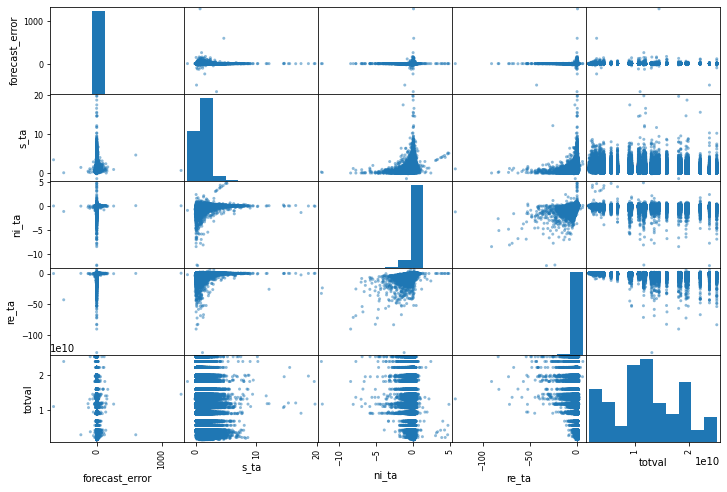

In [363]:
from pandas.plotting import scatter_matrix
attributes = ["forecast_error", "s_ta", "ni_ta","re_ta","totval"]
scatter_matrix(earnings[attributes], figsize = (12,8))

In [452]:
### Prepare the data for machine learning algorithm
earnings = train_set.drop("forecast_error", axis = 1)
earnings_labels = train_set["forecast_error"].copy()

In [453]:
## Numerical attributes
earnings_num = earnings.drop("sic_label", axis =1)
## Handling categorical attribute
earnings_cat = earnings[["sic_label"]]
earnings_cat.head()

,sic_label
34658,Consumer goods
66964,Business Services
62804,Healthcare
63163,Business Services
81975,Electronic Equipment


In [454]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
earnings_cat_1hot = cat_encoder.fit_transform(earnings_cat)
earnings_cat_1hot

<68896x48 sparse matrix of type '<class 'numpy.float64'>'
	with 68896 stored elements in Compressed Sparse Row format>

In [455]:
###Transformation pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# earnings_num_tr = num_pipeline.fit_transform(earnings_num)

In [456]:
from sklearn.compose import ColumnTransformer
num_attribs = list(earnings_num)
cat_attribs = ["sic_label"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(),cat_attribs)
])

earnings_prepared = full_pipeline.fit_transform(earnings)

In [457]:
earnings_prepared

array([[ 0.00147483,  0.00470207, -0.53520098, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06310608,  0.00221428,  0.09191528, ...,  0.        ,
         0.        ,  0.        ],
       [-0.005331  , -0.0097017 , -0.61045493, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.11664751,  0.03923024, -0.66062423, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54884283, -0.09754576, -0.25926983, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22943992,  0.10437431, -0.53520098, ...,  0.        ,
         0.        ,  0.        ]])

In [458]:
### Select and train a model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(earnings_prepared, earnings_labels)

LinearRegression()

In [459]:
some_data = earnings.iloc[:5]
some_labels = earnings_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0.72716153 0.48828709 0.50144541 0.65809166 0.82824814]
Labels: [3.201581027667984, 1.3054900793650792, 1.143893291819983, -0.05263157894736847, 1.1312103594080338]


In [460]:
from sklearn.metrics import mean_squared_error
earnings_predictions = lin_reg.predict(earnings_prepared)
lin_mse = mean_squared_error(earnings_labels, earnings_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

5.646550077933865

In [309]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(earnings_prepared, earnings_labels)

DecisionTreeRegressor()

In [311]:
earnings_predictions = tree_reg.predict(earnings_prepared)
tree_mse = mean_squared_error(earnings_labels, earnings_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.994929241228583e-18

In [312]:
### very bad fit/underfit from linear reg while tree overfits
### better use cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, earnings_prepared, earnings_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [429]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [315]:
display_scores(tree_rmse_scores)

Scores: [ 9.44926756  5.84405332  6.46575934  6.44296123  8.98718609  9.44055803
  5.26987385  5.99971905 18.9916707  23.661682  ]
Mean: 10.055273115878245
Standard deviation: 5.915190912071658


In [461]:
lin_scores = cross_val_score(lin_reg, earnings_prepared, earnings_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 3.8545865  14.03550296  7.35843248  8.27586907 16.48453646  4.82813302
  3.56611164  4.70984453  3.65035175  3.64593233]
Mean: 7.040930074833311
Standard deviation: 4.419403170929532


In [318]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
# forest_reg.fit(earnings_prepared, earnings_labels)
scores = cross_val_score(forest_reg, earnings_prepared, earnings_labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [319]:
display_scores(forest_rmse_scores)

Scores: [ 8.88375711  4.25396244  3.90710278  5.22757449  2.93754321  4.18512902
  3.62032476  5.18860251 18.50280663  3.72861076]
Mean: 6.0435413722039835
Standard deviation: 4.436165063014413


In [ ]:
# The errors are too high for the model to perform well # So this excercise is closed here